In [370]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple
from collections import defaultdict
from pprint import pprint
import pickle

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Add project directory to sys.path
# pdir = os.path.abspath(os.path.join(os.getcwd(), '.'))
# sys.path.insert(1, pdir)
# from myutils import *

# Other module imports
import ast, math, swifter, csv, json, itertools as it, portion as P

# Set plot style
# plt.style.use('ggplot')

# Functiuon Definitions

In [371]:
# ************************************************* unify data format *************************************************

def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = [
            'seq', 'rpkg', 'frame_id', 'Timestamp', 'Timestamp_epoth', 'lost', 'excl', 'latency',
            'xmit_time', 'xmit_time_epoch', 'arr_time', 'arr_time_epoch',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['Timestamp_epoch', 'xmit_time_epoch', 'arr_time_epoch', 'latency']] = \
            df[['Timestamp_epoch', 'xmit_time_epoch', 'arr_time_epoch', 'latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

# ************************************************* Sheng-Ru Latest Version (09-25) add try except (10-27) *************************************************

def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

# ************************************************* parse into readable dataframe *************************************************

def mi_parse_handover(df, tz=8, radical=True):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)

    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-Freq', 'band_cng', 'inter-gNB', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

In [372]:
def handover_classify_labelling(df_ho, df_dl=None, df_ul=None, ratio=0.5, scope=None):
    
    if scope is None:
        scope = {
            'LTEH': (-4.0, 2.0, 0.018),
            'ENBH': (-4.0, 2.6, 0.019),
            'MCGH': (-3.0, 3.3, 0.019),
            'MNBH': (-3.2, 3.3, 0.02),
            'SCGM': (-4.2, 3.3, 0.017),
            'SCGA': (-1.2, 2.6, 0.027),
            'SCGR-I': (-3.1, 3.3, 0.04),
            'SCGC-I': (-3.0, 2.9, 0.37),
            'SCGR-II': (-2.0, 4.1, 0.034),
            'SCGC-II': (-2.0, 3.2, 0.396),
            'MCGF': (-5.8, 7.2, 0.078),
            'NASR': (-4.0, 6.5, 0.394),
            'SCGF': (-4.0, 4.6, 0.111)
        }
        
    def interp(x, y, ratio):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio

    Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
    Duration = namedtuple('Duration', ['total', 'stable', 'unstable'])

    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    E = { stage: { key: [] for key in [*scope.keys(), *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after']}
    E['overview'] = {}

    selected_cols = ['stage', 'category', 'type', 'cause', 'index', 'inter-RAT', 'inter-eNB', 'inter-Freq', 'band_cng', 'inter-gNB']
    reset_values = ['-', 'stable', 'stable', '-', -1, False, False, False, False, False]
    
    dl_start_time, dl_end_time = pd.Timestamp.max, pd.Timestamp.min
    if df_dl is not None:
        dl_start_time, dl_end_time = df_dl.iloc[0]['Timestamp'] - pd.Timedelta(seconds=0.1), df_dl.iloc[-1]['Timestamp'] + pd.Timedelta(seconds=0.1)
        # df_dl = df_dl.reindex(columns=[*list(df_dl.columns), *selected_cols])
        # Reset the specified columns using a loop
        for col, reset_value in zip(selected_cols, reset_values):
            df_dl[col] = reset_value
    
    ul_start_time, ul_end_time = pd.Timestamp.max, pd.Timestamp.min
    if df_ul is not None:
        ul_start_time, ul_end_time = df_ul.iloc[0]['Timestamp'] - pd.Timedelta(seconds=0.1), df_ul.iloc[-1]['Timestamp'] + pd.Timedelta(seconds=0.1)
        # df_ul = df_ul.reindex(columns=[*list(df_ul.columns), *selected_cols])
        # Reset the specified columns using a loop
        for col, reset_value in zip(selected_cols, reset_values):
            df_ul[col] = reset_value
            
    start_time, end_time = min(dl_start_time, ul_start_time), max(dl_end_time, ul_end_time)
    stable_interval = P.open(start_time, end_time)
    for i, row in df_ho.iterrows():
        prior_row = df_ho.iloc[i-1] if i != 0 else None
        post_row = df_ho.iloc[i+1] if i != len(df_ho) - 1 else None
        
        # Peek the next event to avoid HO overlapping with handoverFailure (skip and set the next prior event)
        if i != len(df_ho) - 1 and pd.notna(row.end) and row.end > post_row.start:
            print('Overlapping event occurs!!')
            print(i, row['start'], row['end'], row['type'], row['cause'])
            print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
            continue
        if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
            prior_row = df_ho.iloc[i-2] if i > 1 else None
        
        # Basic information
        tag = row['type']  # specific column name
        cause = row['cause']
        start, end = row['start'], row['end']  # handover start/end time
        intr = (end - start).total_seconds() if pd.notna(end) else 0  # handover interruption time
        ho_info = [row['category'], row['type'], row['cause'], i, row['inter-RAT'], row['inter-eNB'], row['inter-Freq'], row['band_cng'], row['inter-gNB']]
        
        # peri_interval
        if pd.isna(row.end):
            peri_interval = P.singleton(row.start)
        else:
            peri_interval = P.closed(row.start, row.end)

        # prior_interval
        C = row.start + pd.Timedelta(seconds=scope[tag][0])
        D = row.start
        prior_interval = P.closedopen(C, D)
        if ratio is not None and i != 0:
            prior_tag = prior_row['type']
            A = max(prior_row.start, prior_row.end)
            B = max(prior_row.start, prior_row.end) + pd.Timedelta(seconds=scope[prior_tag][1]-scope[prior_tag][2])
            if P.openclosed(A, B).overlaps(prior_interval):
                # print("Overlaps with the previous!")
                bkp = interp(C, B, ratio)
                bkp = max(bkp, A)  # avoid the breakpoint overlapping the previous event's duration
                # bkp = min(max(bkp, A), D)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！可不加！
                prior_interval = P.closedopen(bkp, D)
                if A in prior_interval:
                    prior_interval = P.open(bkp, D)
        
        # post_interval
        C = row.end
        D = row.end + pd.Timedelta(seconds=scope[tag][1]-scope[tag][2])
        post_interval = P.openclosed(C, D)
        if ratio is not None and i != len(df_ho)-1:
            post_tag = post_row['type']
            A = min(post_row.start, post_row.end) + pd.Timedelta(seconds=scope[post_tag][0])
            B = min(post_row.start, post_row.end)
            if P.closedopen(A, B).overlaps(post_interval):
                # print("Overlaps with the following!")
                bkp = interp(A, D, ratio)
                bkp = min(bkp, B)  # avoid the breakpoint overlappint the following event's duration
                # bkp = max(min(bkp, B), C)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！可不加！
                post_interval = P.open(C, bkp)
        
        # calculate lost & excl
        dl_pkt, dl_lost, dl_excl = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        if df_dl is not None:
            for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
                if intv.empty:
                    continue
                filt = (df_dl['arr_time'] >= intv.lower) & (df_dl['arr_time'] < intv.upper)
                tmp = df_dl[filt].copy()
                dl_pkt[i] = len(tmp)
                dl_lost[i] = sum(tmp['lost'])
                dl_excl[i] = sum(~tmp['lost'] & tmp['excl'])
                df_dl.loc[filt, selected_cols] = [stage, *ho_info]
        
        ul_pkt, ul_lost, ul_excl = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        if df_ul is not None:
            for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
                if intv.empty:
                    continue
                filt = (df_ul['xmit_time'] >= intv.lower) & (df_ul['xmit_time'] < intv.upper)
                tmp = df_ul[filt].copy()
                ul_pkt[i] = len(tmp)
                ul_lost[i] = sum(tmp['lost'])
                ul_excl[i] = sum(~tmp['lost'] & tmp['excl'])
                df_ul.loc[filt, selected_cols] = [stage, *ho_info]
        
        # fill in the blank
        for i, (stage, intv) in enumerate(zip(['before', 'during', 'after'], [prior_interval, peri_interval, post_interval])):
            E[stage][tag].append((intv, Metrics(dl_pkt[i], dl_lost[i], dl_excl[i], ul_pkt[i], ul_lost[i], ul_excl[i])))
            if tag in ['MCGF', 'NASR', 'SCGF']:
                E[stage][f'{tag}_{cause}'].append((intv, Metrics(dl_pkt[i], dl_lost[i], dl_excl[i], ul_pkt[i], ul_lost[i], ul_excl[i])))
        
        # update stable interval
        stable_interval = stable_interval - prior_interval - peri_interval - post_interval
    
    stable_dl_pkt, stable_dl_lost, stable_dl_excl = 0, 0, 0
    stable_ul_pkt, stable_ul_lost, stable_ul_excl = 0, 0, 0
    if df_dl is not None:
        tmp = df_dl[df_dl['category'] == 'stable'].copy()
        stable_dl_pkt = len(tmp)
        stable_dl_lost = sum(tmp['lost'])
        stable_dl_excl = sum(~tmp['lost'] & tmp['excl'])
    
    if df_ul is not None:
        tmp = df_ul[df_ul['category'] == 'stable'].copy()
        stable_ul_pkt = len(tmp)
        stable_ul_lost = sum(tmp['lost'])
        stable_ul_excl = sum(~tmp['lost'] & tmp['excl'])
    
    total_duration = (end_time - start_time).total_seconds()
    stable_duration = 0
    for intv in stable_interval:
        if intv.empty:
            continue
        stable_duration += (intv.upper - intv.lower).total_seconds()
    unstable_duration = total_duration - stable_duration
    
    E['overview']['stable_intv'] = (stable_interval, Metrics(stable_dl_pkt, stable_dl_lost, stable_dl_excl, stable_ul_pkt, stable_ul_lost, stable_ul_excl))
    E['overview']['duration'] = Duration(total_duration, stable_duration, unstable_duration)

    return E, df_dl, df_ul

In [373]:
def metrics_duration_into_dict(E):
    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    A = { stage: { key: [] for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
                                    'MCGF', 'NASR', 'SCGF', *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after'] }
    A['overview'] = {}

    for stage in ['before', 'during', 'after']:
        for tag, lst in E[stage].items():
            for item in lst:
                A[stage][tag].append((item[0], item[1]._asdict()))
    A['overview']['stable_intv'] = (E['overview']['stable_intv'][0], E['overview']['stable_intv'][1]._asdict())
    A['overview']['duration'] = E['overview']['duration']._asdict()
    
    return A

def dict_into_metrics_duration(A):
    Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
    Duration = namedtuple('Duration', ['total', 'stable', 'unstable'])

    mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
    scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

    B = { stage: { key: [] for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
                                    'MCGF', 'NASR', 'SCGF', *mcgf, *nasr, *scgf] } for stage in ['before', 'during', 'after'] }
    B['overview'] = {}

    for stage in ['before', 'during', 'after']:
        for tag, lst in A[stage].items():
            for item in lst:
                B[stage][tag].append((item[0], Metrics(**item[1])))
    B['overview']['stable_intv'] = (A['overview']['stable_intv'][0], Metrics(**A['overview']['stable_intv'][1]))
    B['overview']['duration'] = Duration(**A['overview']['duration'])
    
    return B

In [374]:
evt_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II', # HO
    'MCGF', 'NASR', 'SCGF', # RLF
    'CXNS', 'CXNR', 'SCLA', # Others
]

evt_category = {
    'HO': {
        'intra-RAT 4G': ['LTEH', 'ENBH', 'MCGH', 'MNBH'],
        'intra-RAT 5G': ['SCGM'],
        'inter-RAT': ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']
    },
    'RLF': {
        'MCGF': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)'],
        'NASR': ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)'],
        'SCGF': ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']
    }
}

# Single Testing

In [375]:
rrc_file = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_UDP_8_Phone/sm01/#02/data/diag_log_sm01_2023-05-26_13-36-22_rrc.csv"
dl_file = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_UDP_8_Phone/sm01/#02/data/udp_dnlk_loss_latency.csv"
ul_file = "/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_UDP_8_Phone/sm01/#02/data/udp_uplk_loss_latency.csv"

In [376]:
mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

evt_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', *mcgf,
    'NASR', *nasr,
    'SCGF', *scgf,
]

# record all traces' info in each type list
D = {tag: [] for tag in evt_types}
D['stable_mets'] = []
D['duration'] = []

Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
Stats = namedtuple('Stats', ['count', 'duration', 'metrics'])
Stage = namedtuple('Stage', ['before', 'during', 'after'])

########### in for loop (iterating exprs) ##### start
df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)
df_dl = set_data(pd.read_csv(dl_file))
df_ul = set_data(pd.read_csv(ul_file))
E, df_dl, df_ul = handover_classify_labelling(df_ho, df_dl, df_ul)

# store handover labelling to avoid parsing again and again
df_dl.to_pickle(os.path.join(os.path.dirname(dl_file), 'udp_dnlk_loss_latency_ho.pkl'))
df_ul.to_pickle(os.path.join(os.path.dirname(ul_file), 'udp_uplk_loss_latency_ho.pkl'))
with open(os.path.join(os.path.dirname(rrc_file), 'single_radio_ho_stats.pkl'), 'wb') as f:
    pickle.dump(metrics_duration_into_dict(E), f)

for tag in evt_types:
    # print(tag)
    infos = []
    for i, stage in enumerate(['before', 'during', 'after']):
        # count
        count = len(E[stage][tag])
        # duration
        duration = 0
        intv_list = [item[0] for item in E[stage][tag]]
        for intv in intv_list:
            if intv.empty:
                continue
            duration += (intv.upper - intv.lower).total_seconds()
        # metrics
        mets_list = [item[1] for item in E[stage][tag]]
        metrics = Metrics(sum([item.dl_pkt for item in mets_list]), sum([item.dl_lost for item in mets_list]), sum([item.dl_excl for item in mets_list]), sum([item.ul_pkt for item in mets_list]), sum([item.ul_lost for item in mets_list]), sum([item.ul_excl for item in mets_list]))
        
        # print(stage, count, duration, metrics)
        infos.append(Stats(count, duration, metrics))
    D[tag].append(Stage(*infos))
    
D['stable_mets'].append(E['overview']['stable_intv'][1])
D['duration'].append(E['overview']['duration'])
########### in for loop (iterating exprs) ##### end

pprint(D, sort_dicts=False)

{1750: 3.0}
{'LTEH': [Stage(before=Stats(count=0, duration=0, metrics=Metrics(dl_pkt=0, dl_lost=0, dl_excl=0, ul_pkt=0, ul_lost=0, ul_excl=0)), during=Stats(count=0, duration=0, metrics=Metrics(dl_pkt=0, dl_lost=0, dl_excl=0, ul_pkt=0, ul_lost=0, ul_excl=0)), after=Stats(count=0, duration=0, metrics=Metrics(dl_pkt=0, dl_lost=0, dl_excl=0, ul_pkt=0, ul_lost=0, ul_excl=0)))],
 'ENBH': [Stage(before=Stats(count=1, duration=0, metrics=Metrics(dl_pkt=0, dl_lost=0, dl_excl=0, ul_pkt=0, ul_lost=0, ul_excl=0)), during=Stats(count=1, duration=0.018717, metrics=Metrics(dl_pkt=8, dl_lost=8, dl_excl=0, ul_pkt=0, ul_lost=0, ul_excl=0)), after=Stats(count=1, duration=2.581, metrics=Metrics(dl_pkt=1305, dl_lost=61, dl_excl=66, ul_pkt=1416, ul_lost=1, ul_excl=385)))],
 'MCGH': [Stage(before=Stats(count=4, duration=4.682072, metrics=Metrics(dl_pkt=2163, dl_lost=0, dl_excl=0, ul_pkt=2161, ul_lost=0, ul_excl=0)), during=Stats(count=4, duration=0.0664, metrics=Metrics(dl_pkt=24, dl_lost=0, dl_excl=0, ul_p

## Plotting

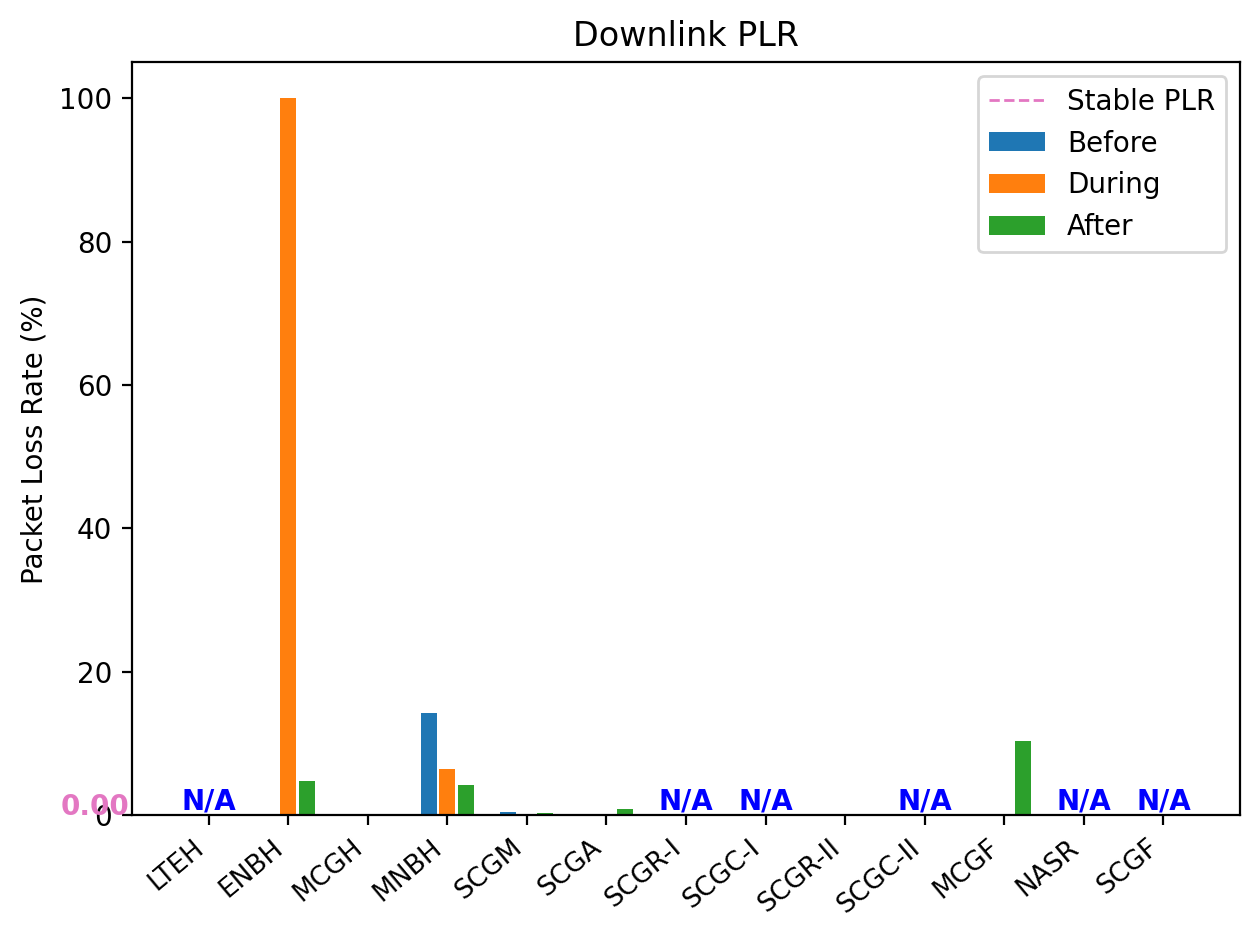

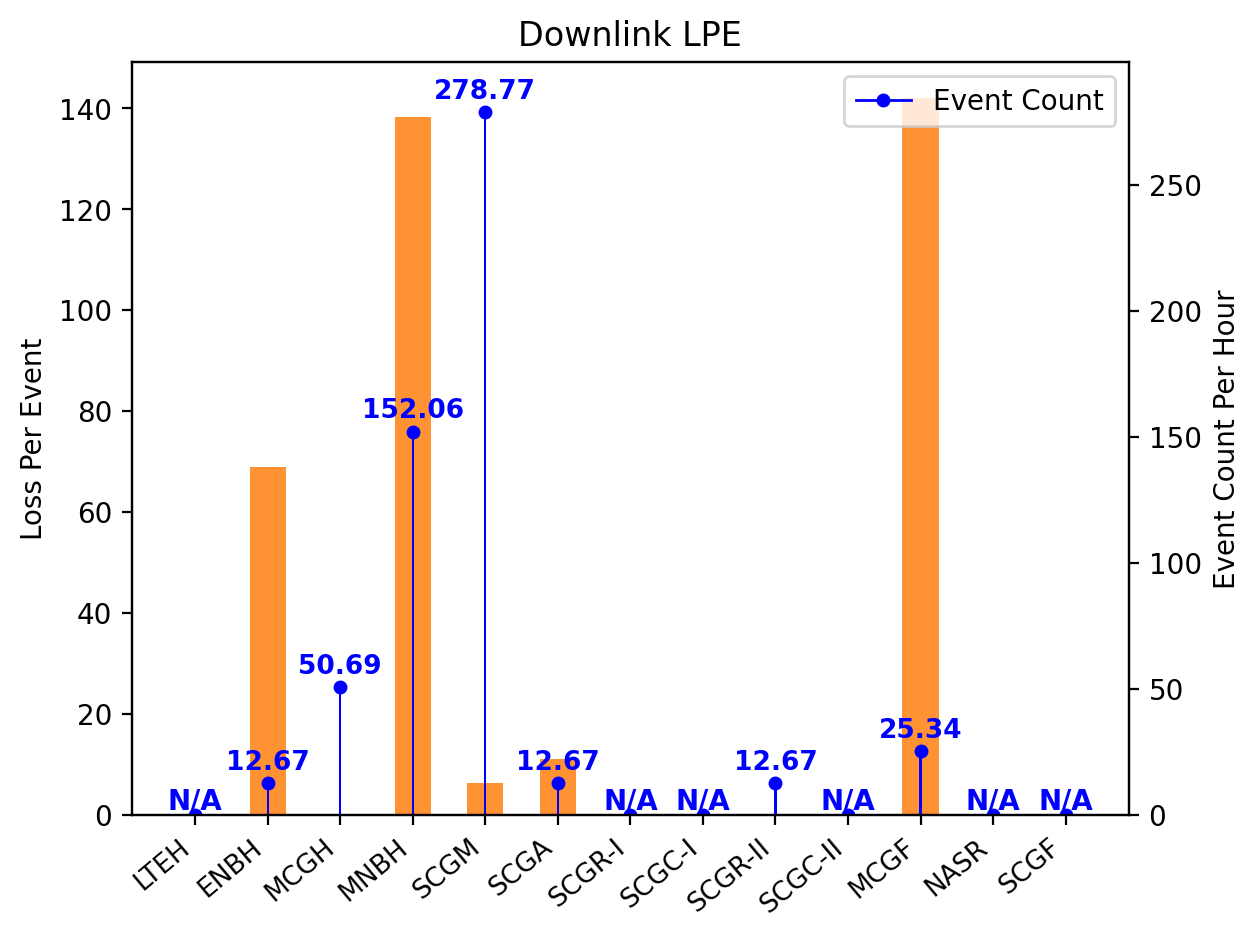

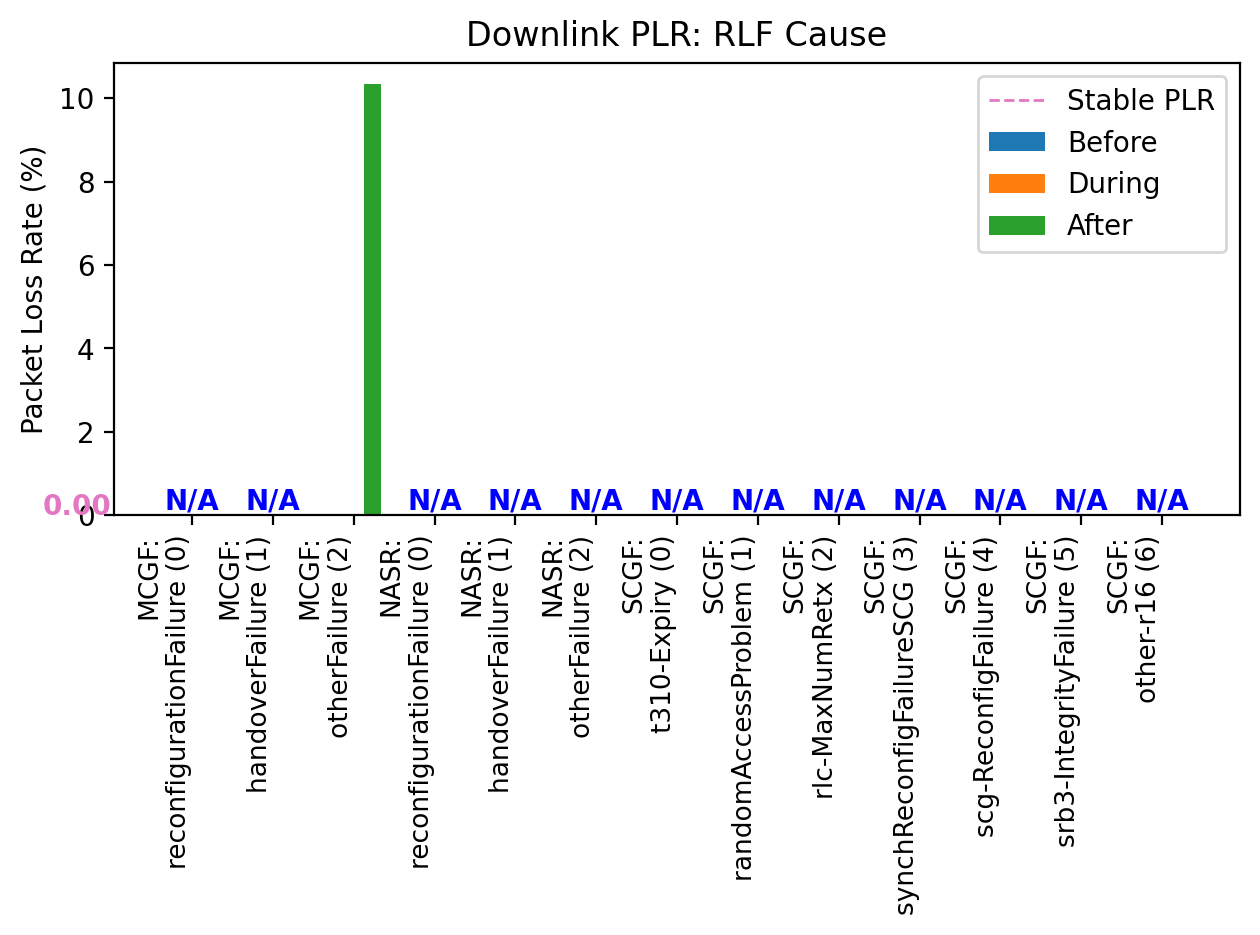

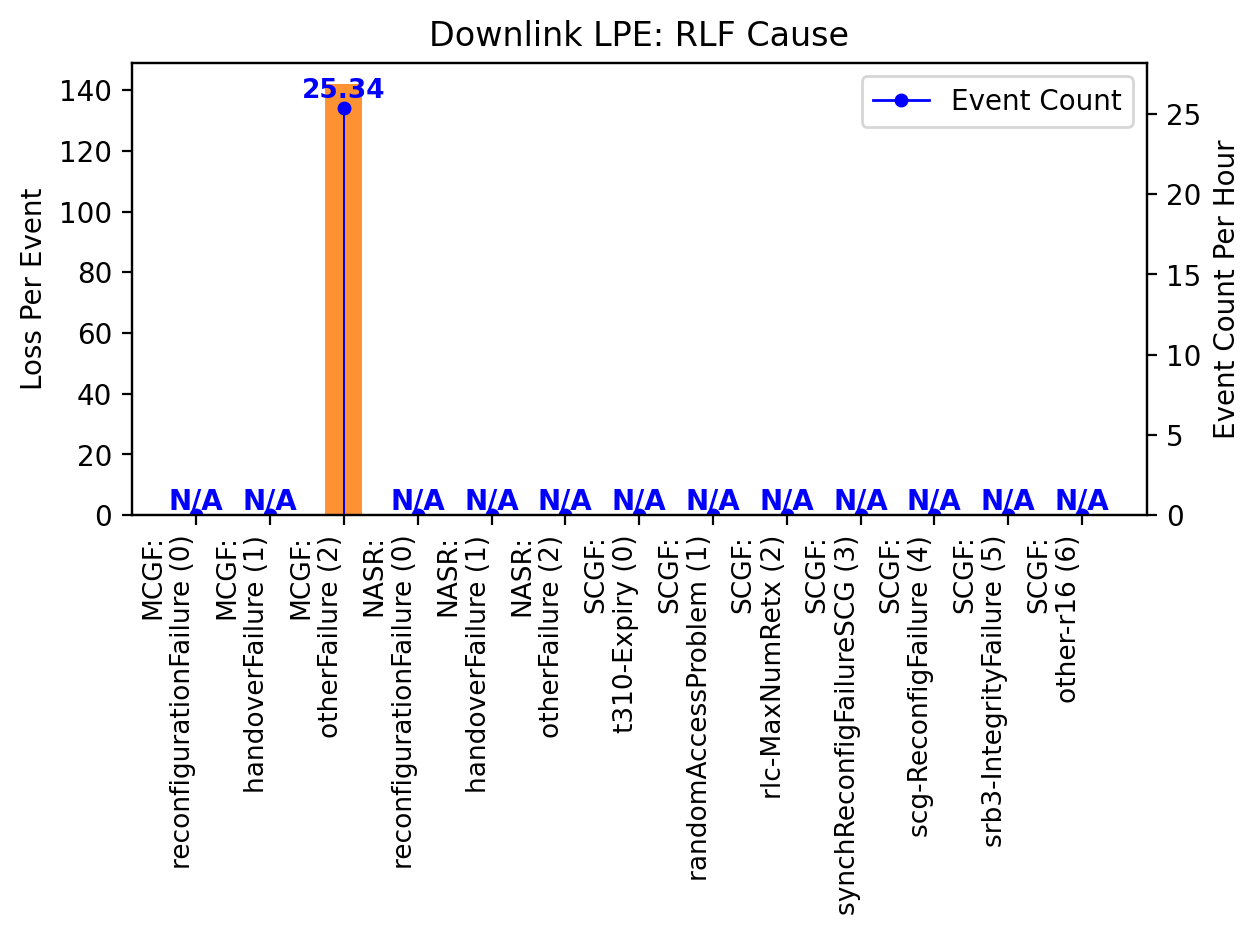

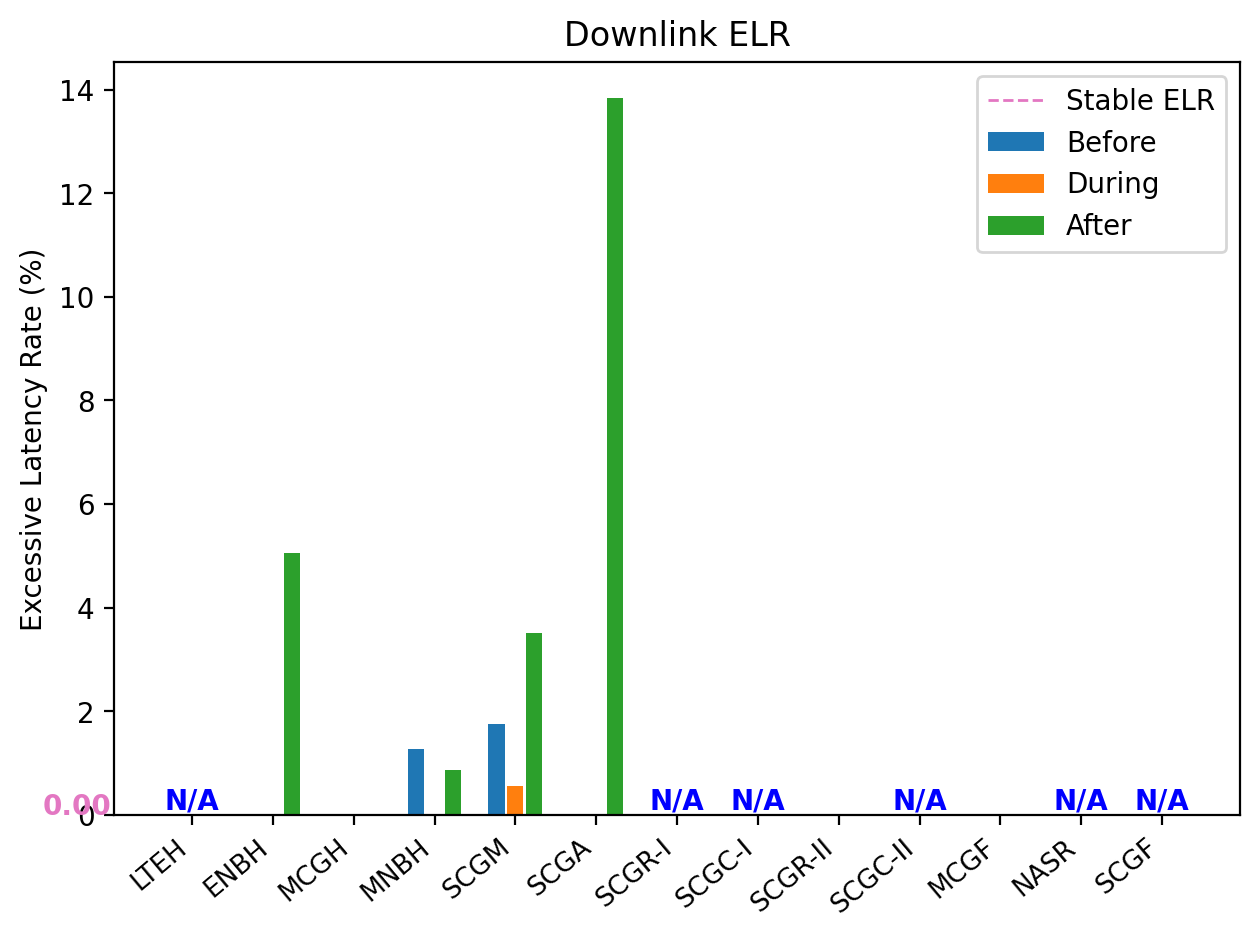

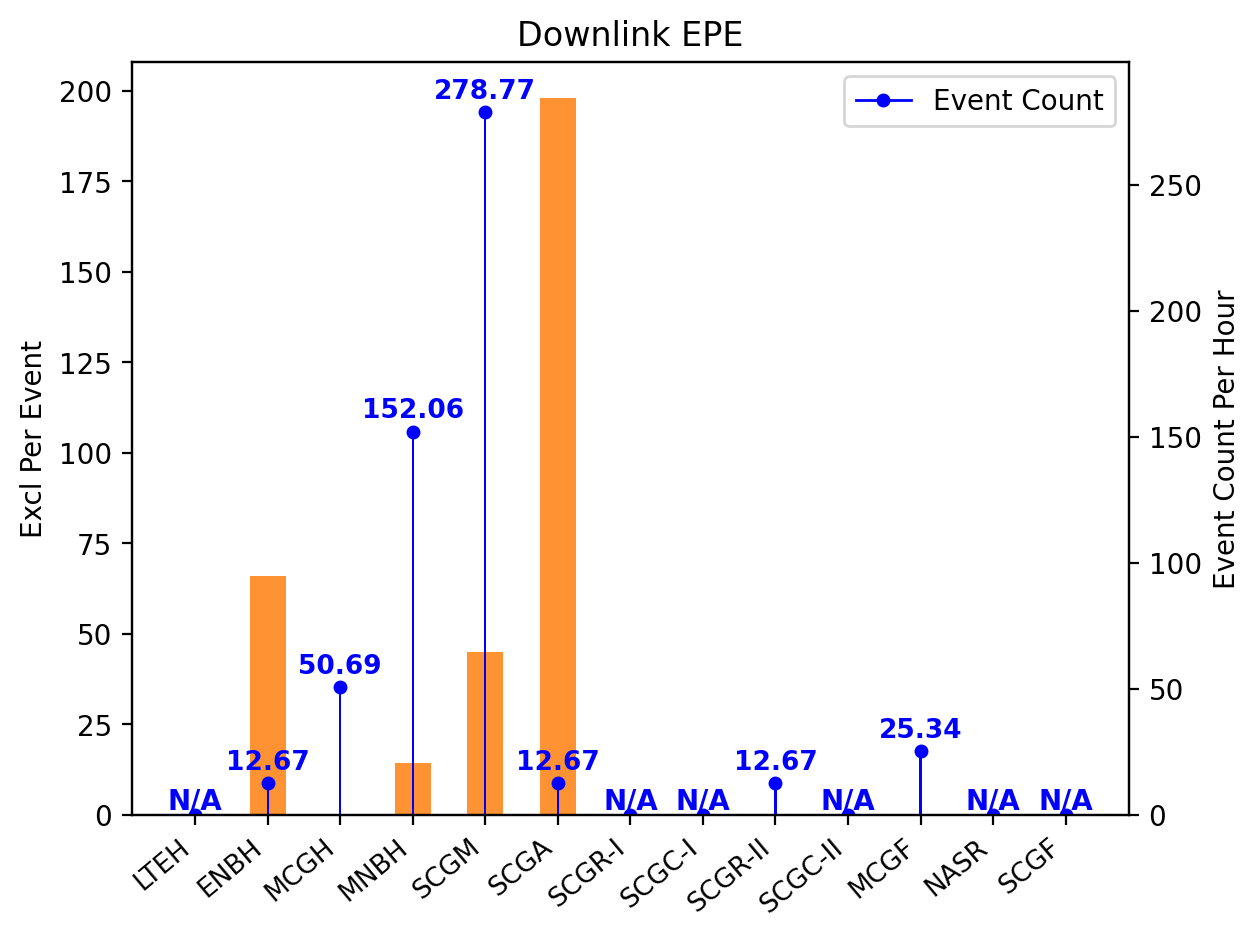

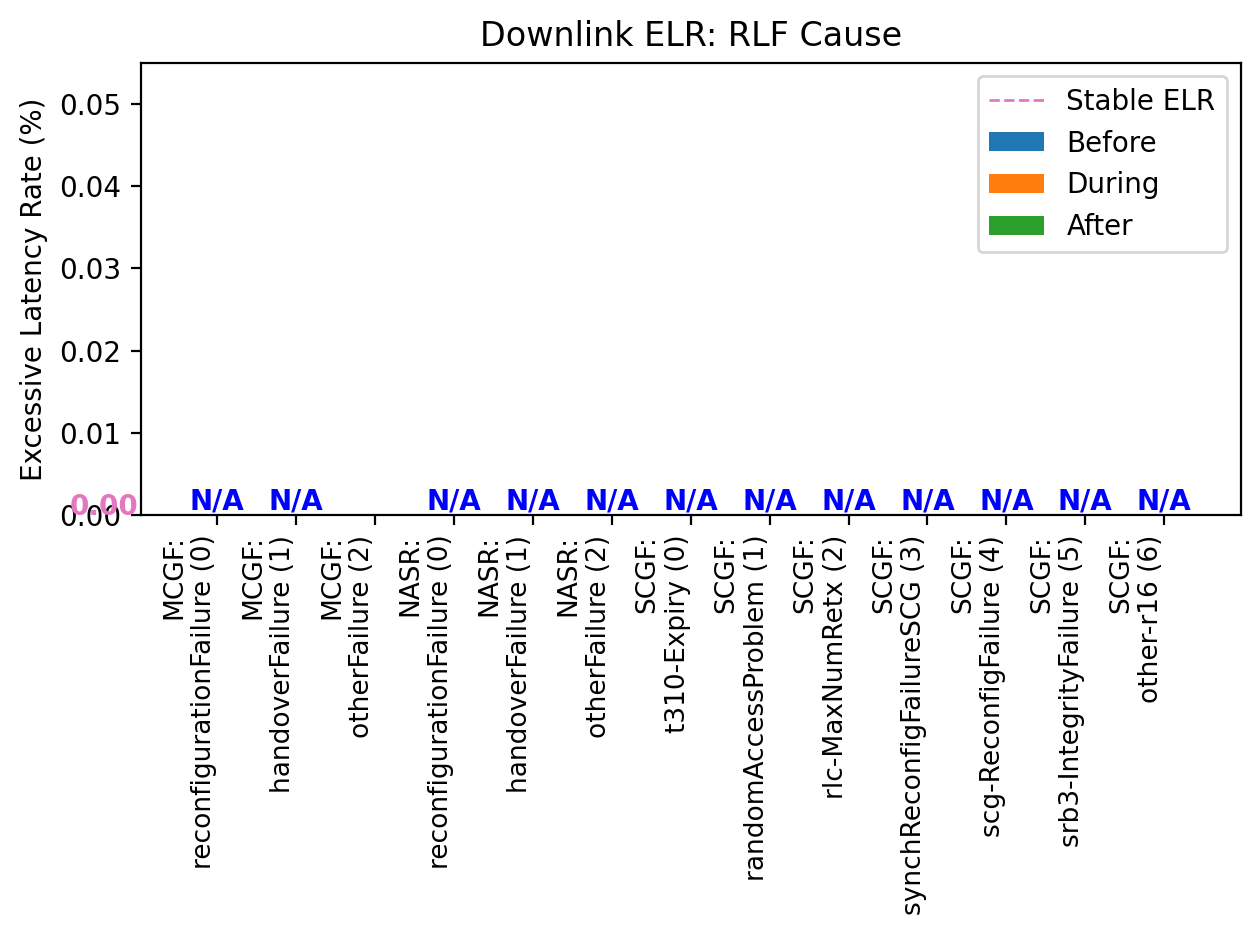

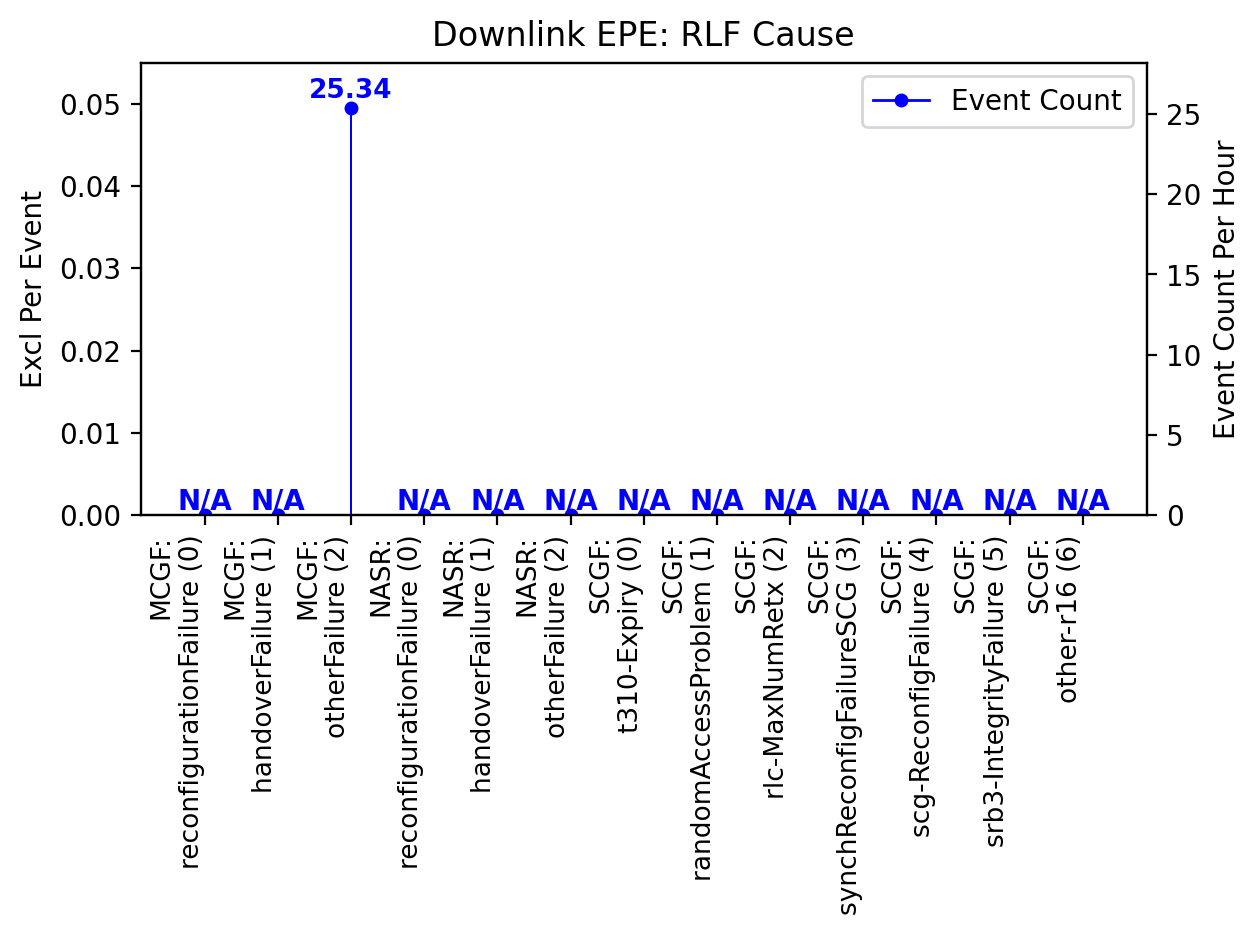

In [377]:
# ****************************************** PLR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** PLR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()

# Single Metrics Chart

## Airport Line

In [378]:
filenames = []

root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"
date_dirs = ['2023-10-26']
date_dirs = [os.path.join(root_dir, s) for s in sorted(date_dirs)]

for date_dir in date_dirs:
    exp_dirs = [s for s in os.listdir(date_dir) if os.path.isdir(os.path.join(date_dir, s)) and s != '.DS_Store']
    exp_dirs = [os.path.join(date_dir, s) for s in sorted(exp_dirs)]
    for exp_dir in exp_dirs:
        dev_dirs = [s for s in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, s)) and s != '.DS_Store']
        dev_dirs = [os.path.join(exp_dir, s) for s in sorted(dev_dirs)]
        for dev_dir in dev_dirs:
            trip_dirs = [s for s in os.listdir(dev_dir) if os.path.isdir(os.path.join(dev_dir, s)) and s != '.DS_Store']
            trip_dirs = [os.path.join(dev_dir, s, 'data') for s in sorted(trip_dirs)]
            for trip_dir in trip_dirs:
                # print(trip_dir)
                rrc_file = [os.path.join(trip_dir, s) for s in os.listdir(trip_dir) if s.endswith('rrc.csv')][0]
                dl_file = os.path.join(trip_dir, 'udp_dnlk_loss_latency.csv')
                ul_file = os.path.join(trip_dir, 'udp_uplk_loss_latency.csv')
                # print(rrc_file, os.path.isfile(rrc_file))
                # print(dl_file, os.path.isfile(dl_file))
                # print(ul_file, os.path.isfile(ul_file))
                filenames.append((rrc_file, dl_file, ul_file))
                
pprint(filenames, sort_dicts=False)

[('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#01/data/diag_log_sm00_2023-10-26_13-30-26_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#01/data/udp_uplk_loss_latency.csv'),
 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-10-26_14-25-43_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#02/data/udp_uplk_loss_latency.csv'),
 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-10-26_13-30-25_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm01/#01/data/udp_dnlk_loss_latency.csv'

In [379]:
mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

evt_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', *mcgf,
    'NASR', *nasr,
    'SCGF', *scgf,
]

# record all traces' info in each type list
D = {tag: [] for tag in evt_types}
D['stable_mets'] = []
D['duration'] = []

Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
Stats = namedtuple('Stats', ['count', 'duration', 'metrics'])
Stage = namedtuple('Stage', ['before', 'during', 'after'])

for i, (rrc_file, dl_file, ul_file) in enumerate(filenames):
    ########### in for loop (iterating exprs) ##### start
    print(i, (rrc_file, dl_file, ul_file))
    df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)
    if df_ho.empty:
        continue
    
    df_dl = set_data(pd.read_csv(dl_file))
    df_ul = set_data(pd.read_csv(ul_file))
    E, df_dl, df_ul = handover_classify_labelling(df_ho, df_dl, df_ul)
    
    # store handover labelling to avoid parsing again and again
    df_dl.to_pickle(os.path.join(os.path.dirname(dl_file), 'udp_dnlk_loss_latency_ho.pkl'))
    df_ul.to_pickle(os.path.join(os.path.dirname(ul_file), 'udp_uplk_loss_latency_ho.pkl'))
    with open(os.path.join(os.path.dirname(rrc_file), 'single_radio_ho_stats.pkl'), 'wb') as f:
        pickle.dump(metrics_duration_into_dict(E), f)

    for tag in evt_types:
        # print(tag)
        infos = []
        for i, stage in enumerate(['before', 'during', 'after']):
            # count
            count = len(E[stage][tag])
            # duration
            duration = 0
            intv_list = [item[0] for item in E[stage][tag]]
            for intv in intv_list:
                if intv.empty:
                    continue
                duration += (intv.upper - intv.lower).total_seconds()
            # metrics
            mets_list = [item[1] for item in E[stage][tag]]
            metrics = Metrics(sum([item.dl_pkt for item in mets_list]), sum([item.dl_lost for item in mets_list]), sum([item.dl_excl for item in mets_list]), sum([item.ul_pkt for item in mets_list]), sum([item.ul_lost for item in mets_list]), sum([item.ul_excl for item in mets_list]))
            
            # print(stage, count, duration, metrics)
            infos.append(Stats(count, duration, metrics))
        D[tag].append(Stage(*infos))
        
    D['stable_mets'].append(E['overview']['stable_intv'][1])
    D['duration'].append(E['overview']['duration'])
    ########### in for loop (iterating exprs) ##### end

# pprint(D, sort_dicts=False)

0 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#01/data/diag_log_sm00_2023-10-26_13-30-26_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/Bandlock_UDP_9_Phone/sm00/#01/data/udp_uplk_loss_latency.csv')
{3050: 7.0, 1750: 3.0, 3650: 8.0, 1400: 3.0}
Overlapping event occurs!!
70 2023-10-26 13:36:28.619534 2023-10-26 13:36:29.210426 SCGF t310-Expiry (0)
71 2023-10-26 13:36:29.128267 2023-10-26 13:36:29.210426 MCGF otherFailure (2)
Overlapping event occurs!!
155 2023-10-26 13:45:20.055475 2023-10-26 13:45:20.967580 SCGC-II nan
156 2023-10-26 13:45:20.542184 2023-10-26 13:45:20.573187 ENBH nan
Overlapping event occurs!!
161 2023-10-26 13:45:44.134646 2023-10-26 13:45:44.743912 SCGR-II nan
162 2023-10-26 13:45:44.580797 2023-10-26 13:45:44.652896 MCGF handoverFailure (1)
Overlapping event occurs!!
188 2023-10-26 13:49:58.511813

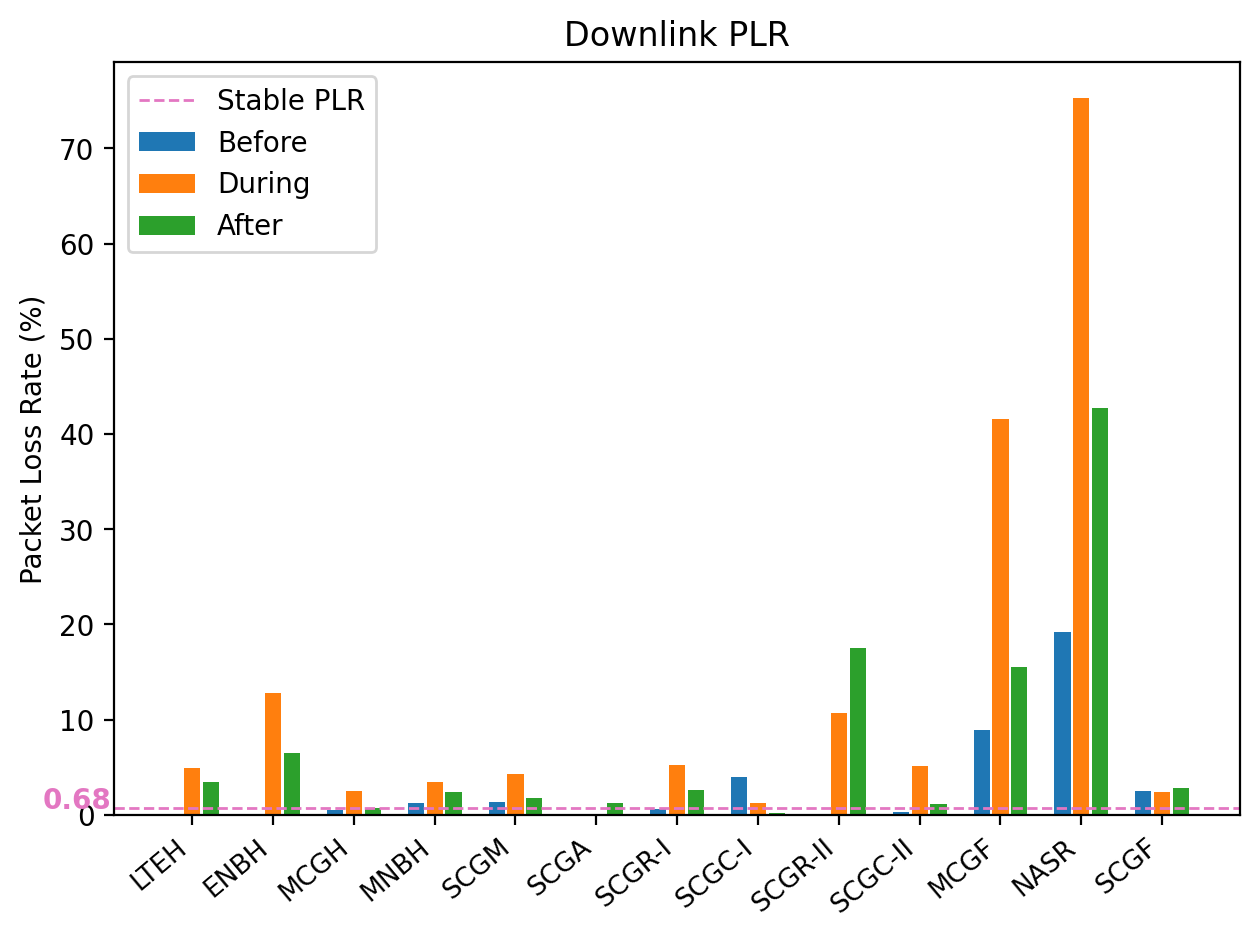

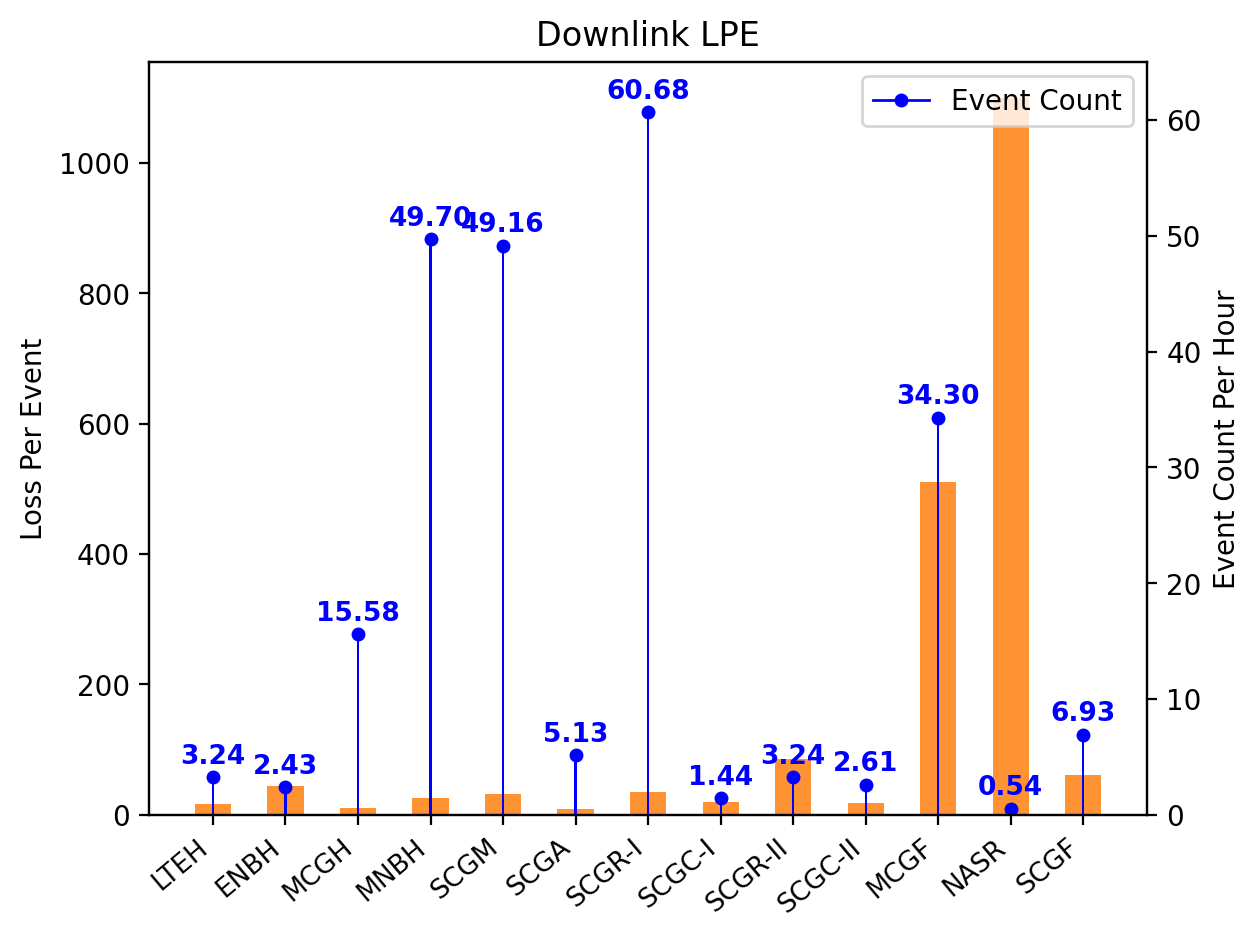

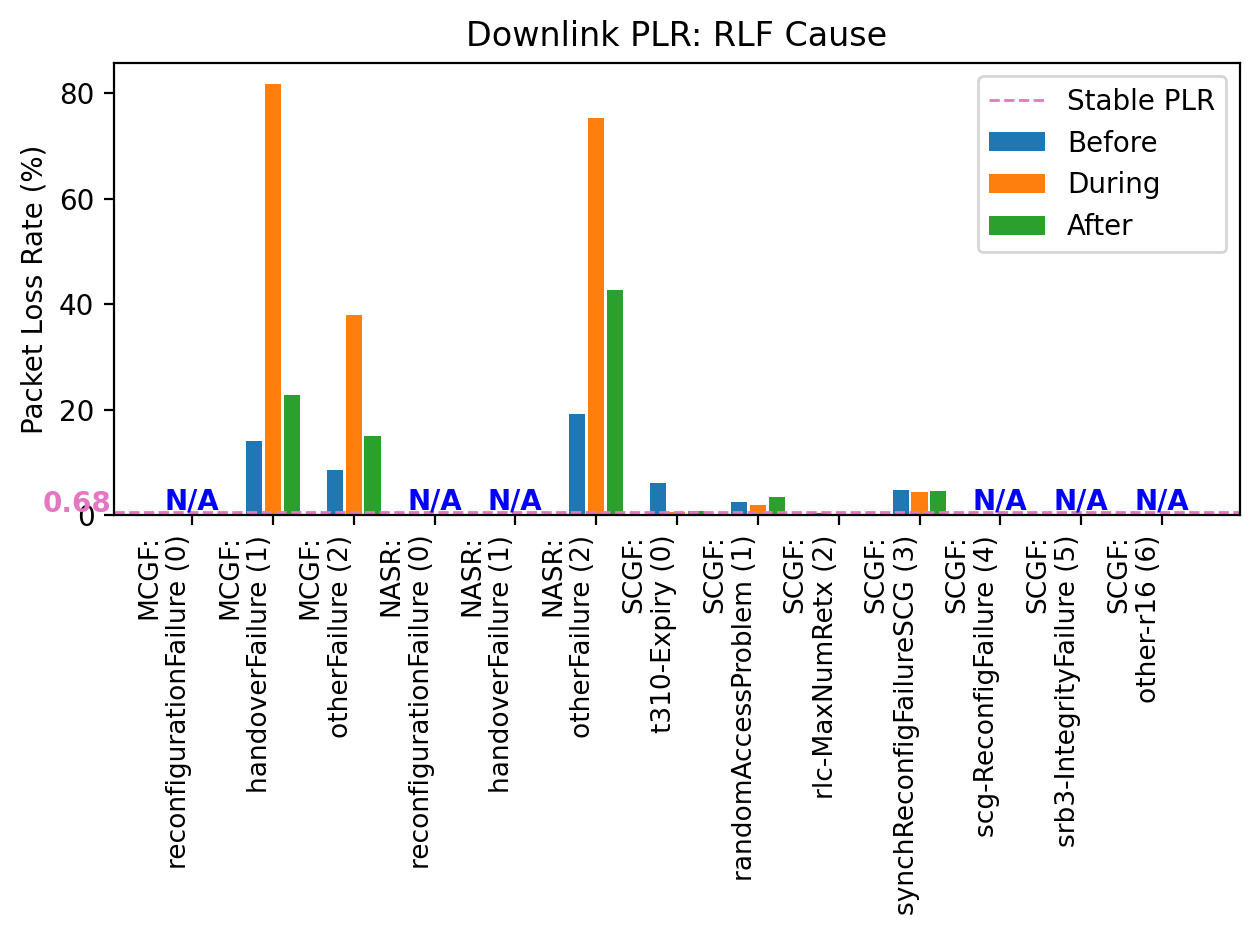

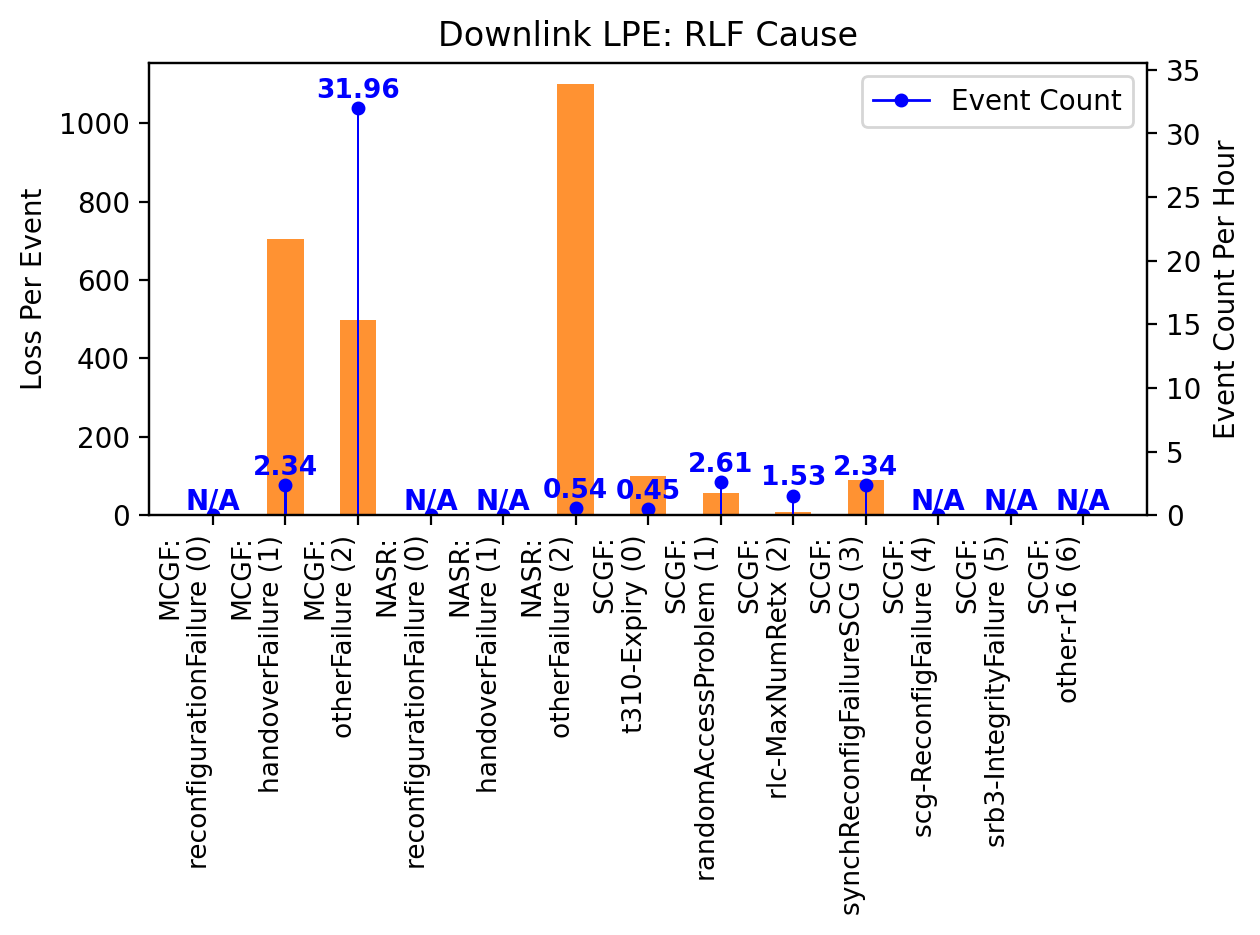

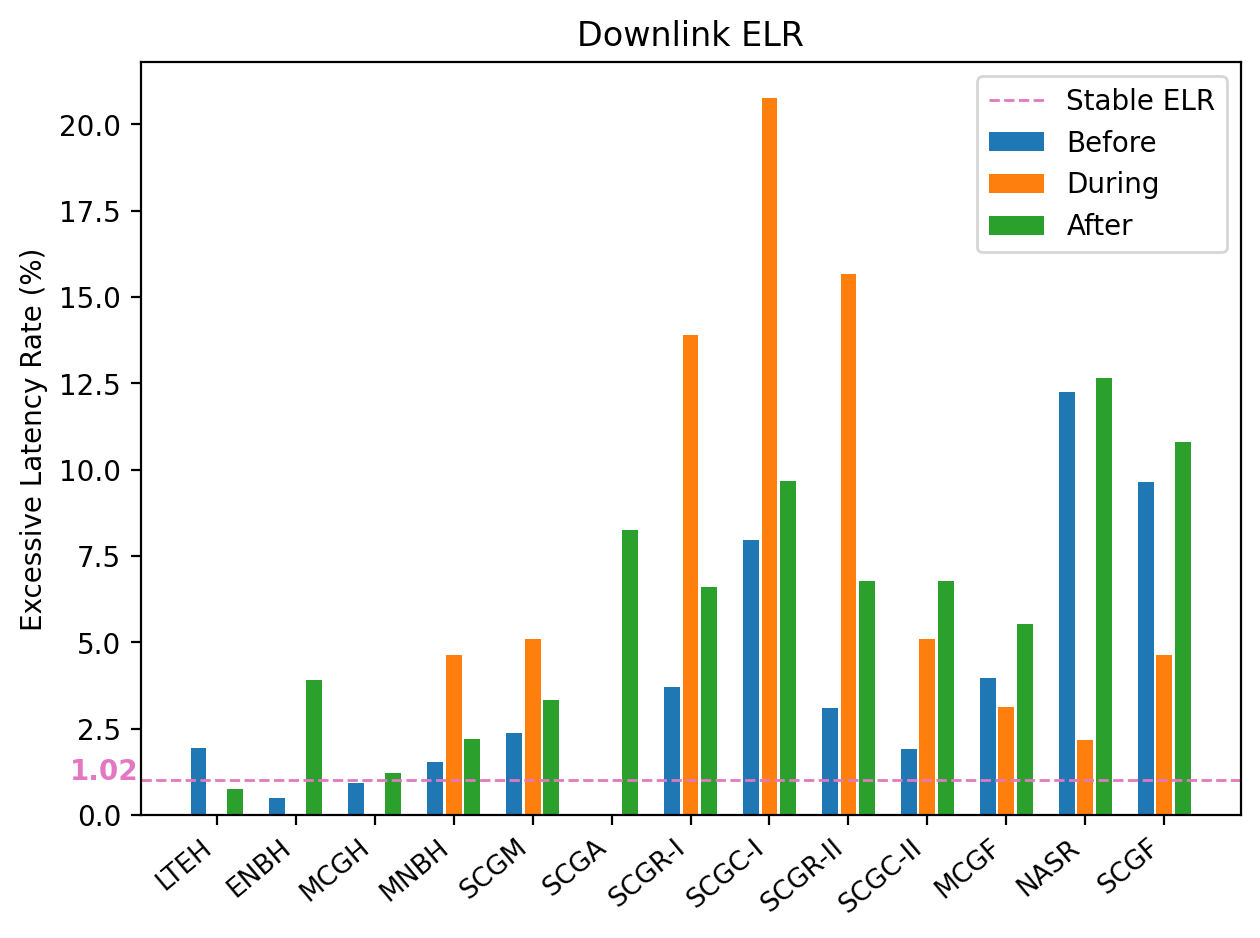

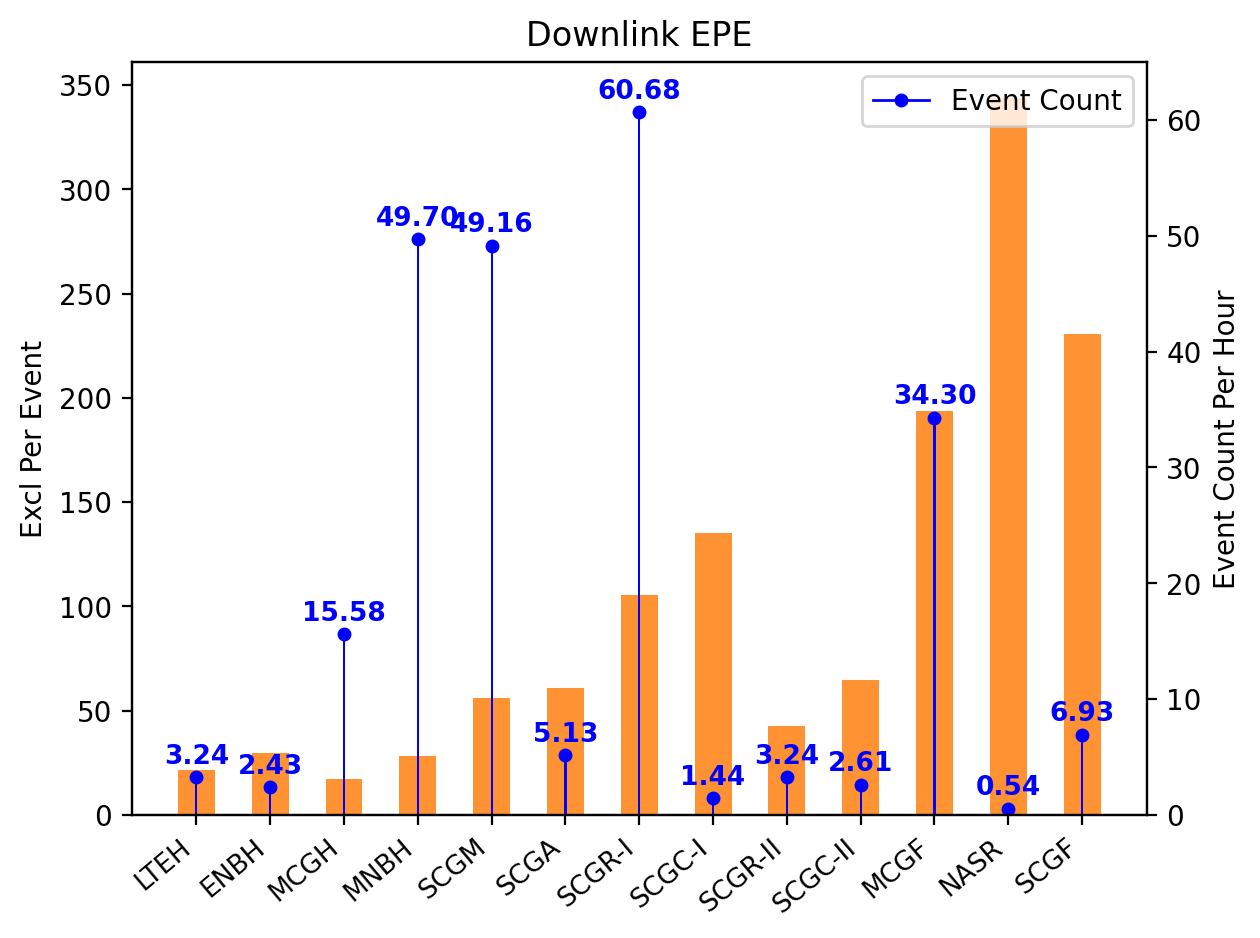

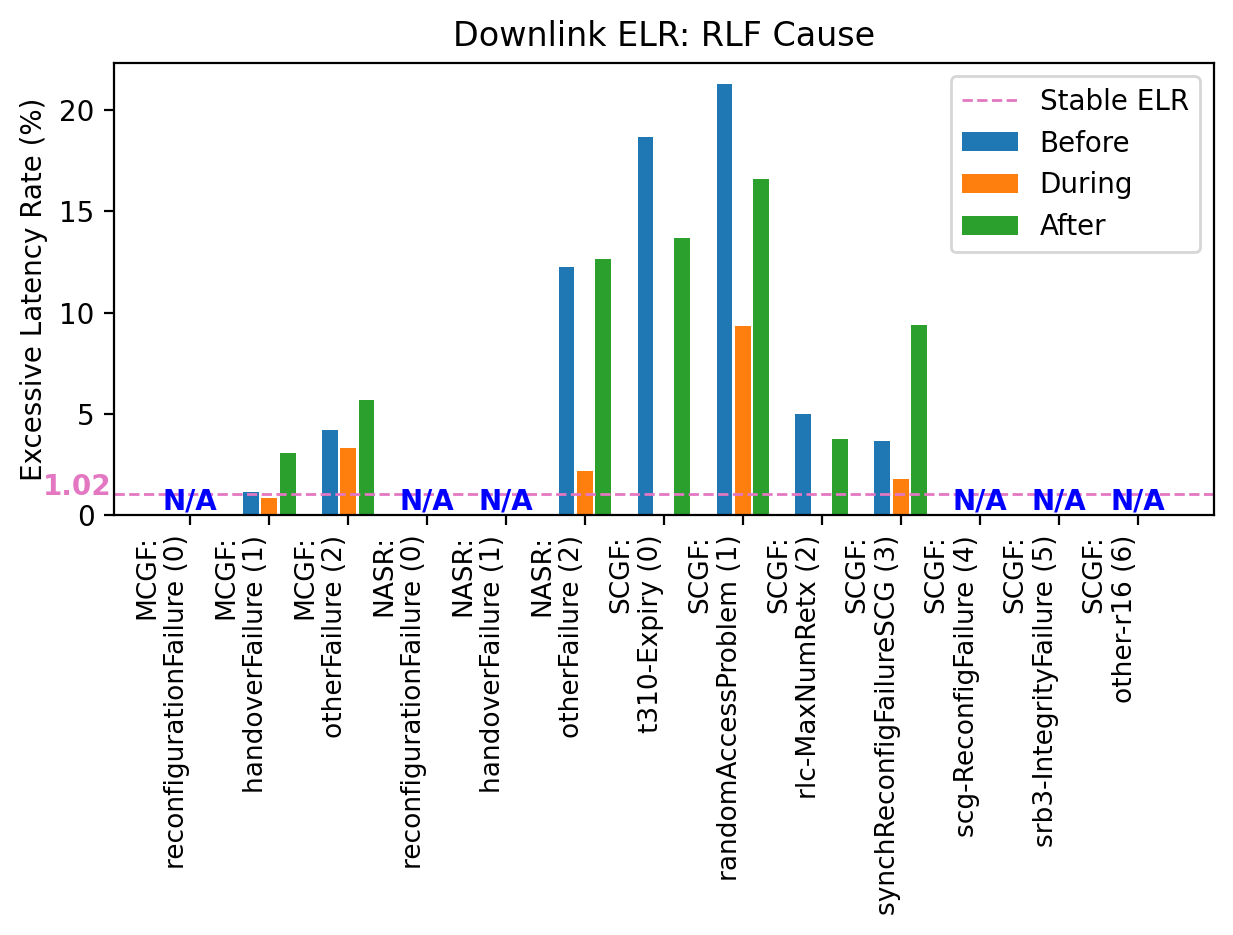

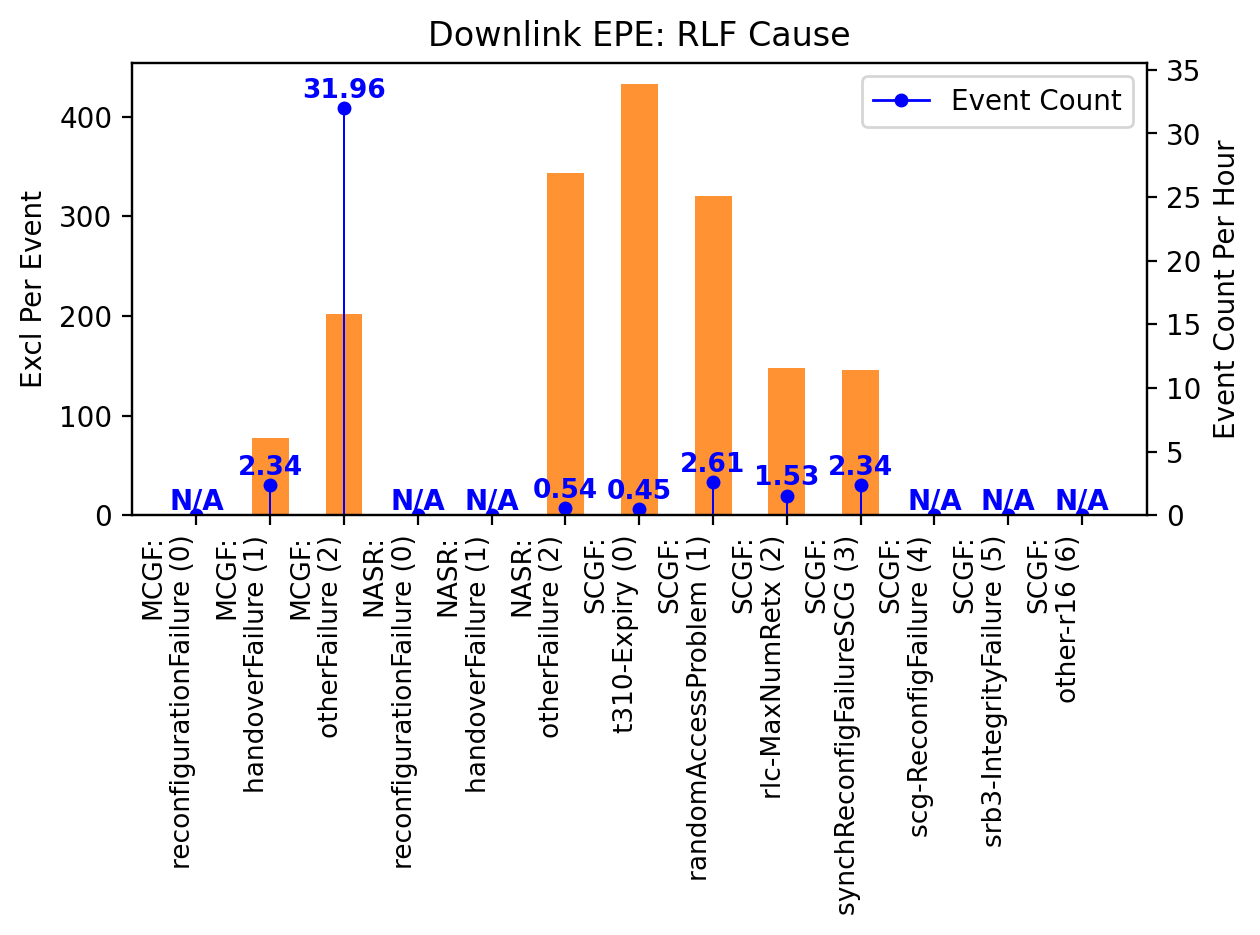

In [380]:
# ****************************************** PLR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** PLR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()

## Brown Line

In [381]:
filenames = []

root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"
date_dirs = ['2023-09-12', '2023-09-21']
date_dirs = [os.path.join(root_dir, s) for s in sorted(date_dirs)]

for date_dir in date_dirs:
    exp_dirs = [s for s in os.listdir(date_dir) if os.path.isdir(os.path.join(date_dir, s)) and s != '.DS_Store']
    exp_dirs = [os.path.join(date_dir, s) for s in sorted(exp_dirs)]
    for exp_dir in exp_dirs:
        dev_dirs = [s for s in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, s)) and s != '.DS_Store']
        dev_dirs = [os.path.join(exp_dir, s) for s in sorted(dev_dirs)]
        for dev_dir in dev_dirs:
            trip_dirs = [s for s in os.listdir(dev_dir) if os.path.isdir(os.path.join(dev_dir, s)) and s != '.DS_Store']
            trip_dirs = [os.path.join(dev_dir, s, 'data') for s in sorted(trip_dirs)]
            for trip_dir in trip_dirs:
                # print(trip_dir)
                rrc_file = [os.path.join(trip_dir, s) for s in os.listdir(trip_dir) if s.endswith('rrc.csv')][0]
                dl_file = os.path.join(trip_dir, 'udp_dnlk_loss_latency.csv')
                ul_file = os.path.join(trip_dir, 'udp_uplk_loss_latency.csv')
                # print(rrc_file, os.path.isfile(rrc_file))
                # print(dl_file, os.path.isfile(dl_file))
                # print(ul_file, os.path.isfile(ul_file))
                filenames.append((rrc_file, dl_file, ul_file))
                
pprint(filenames, sort_dicts=False)

[('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#01/data/udp_uplk_loss_latency.csv'),
 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-09-12_14-52-28_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#02/data/udp_uplk_loss_latency.csv'),
 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-09-12_13-34-15_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#01/data/udp_dnlk_loss_latency.csv'

In [382]:
mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

evt_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', *mcgf,
    'NASR', *nasr,
    'SCGF', *scgf,
]

# record all traces' info in each type list
D = {tag: [] for tag in evt_types}
D['stable_mets'] = []
D['duration'] = []

Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
Stats = namedtuple('Stats', ['count', 'duration', 'metrics'])
Stage = namedtuple('Stage', ['before', 'during', 'after'])

for i, (rrc_file, dl_file, ul_file) in enumerate(filenames):
    ########### in for loop (iterating exprs) ##### start
    print(i, (rrc_file, dl_file, ul_file))
    df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)
    if df_ho.empty:
        continue
    
    df_dl = set_data(pd.read_csv(dl_file))
    df_ul = set_data(pd.read_csv(ul_file))
    E, df_dl, df_ul = handover_classify_labelling(df_ho, df_dl, df_ul)
    
    # store handover labelling to avoid parsing again and again
    df_dl.to_pickle(os.path.join(os.path.dirname(dl_file), 'udp_dnlk_loss_latency_ho.pkl'))
    df_ul.to_pickle(os.path.join(os.path.dirname(ul_file), 'udp_uplk_loss_latency_ho.pkl'))
    with open(os.path.join(os.path.dirname(rrc_file), 'single_radio_ho_stats.pkl'), 'wb') as f:
        pickle.dump(metrics_duration_into_dict(E), f)

    for tag in evt_types:
        # print(tag)
        infos = []
        for i, stage in enumerate(['before', 'during', 'after']):
            # count
            count = len(E[stage][tag])
            # duration
            duration = 0
            intv_list = [item[0] for item in E[stage][tag]]
            for intv in intv_list:
                if intv.empty:
                    continue
                duration += (intv.upper - intv.lower).total_seconds()
            # metrics
            mets_list = [item[1] for item in E[stage][tag]]
            metrics = Metrics(sum([item.dl_pkt for item in mets_list]), sum([item.dl_lost for item in mets_list]), sum([item.dl_excl for item in mets_list]), sum([item.ul_pkt for item in mets_list]), sum([item.ul_lost for item in mets_list]), sum([item.ul_excl for item in mets_list]))
            
            # print(stage, count, duration, metrics)
            infos.append(Stats(count, duration, metrics))
        D[tag].append(Stage(*infos))
        
    D['stable_mets'].append(E['overview']['stable_intv'][1])
    D['duration'].append(E['overview']['duration'])
    ########### in for loop (iterating exprs) ##### end

# pprint(D, sort_dicts=False)

0 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#01/data/udp_uplk_loss_latency.csv')


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_41364/3377234050.py:24: DtypeWarning: Columns (26,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)


{3050: 7.0, 1750: 3.0}
1 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-09-12_14-52-28_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm00/#02/data/udp_uplk_loss_latency.csv')


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_41364/3377234050.py:24: DtypeWarning: Columns (26,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)


{3050: 7.0, 1750: 3.0, 1400: 3.0}
2 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-09-12_13-34-15_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#01/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#01/data/udp_uplk_loss_latency.csv')
{3050: 7.0, 1750: 3.0, 3650: 8.0}
Overlapping event occurs!!
221 2023-09-12 14:06:05.569537 2023-09-12 14:06:06.256488 MCGH nan
222 2023-09-12 14:06:06.013349 2023-09-12 14:06:06.193295 MCGF handoverFailure (1)
3 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#02/data/diag_log_sm01_2023-09-12_14-52-27_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#02/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12/Bandlock_UDP_9_Phone/sm01/#02/data/udp_uplk_loss_latency.csv')
{3050: 7.0, 175

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_41364/3377234050.py:24: DtypeWarning: Columns (26,40,41,42,43,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)


{3050: 7.0, 1750: 3.0, 1400: 3.0}
19 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-09-21_15-28-46_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm00/#02/data/udp_uplk_loss_latency.csv')


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_41364/3377234050.py:24: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)


{1750: 3.0, 1400: 3.0}
Overlapping event occurs!!
65 2023-09-21 15:42:09.878421 2023-09-21 15:42:10.446326 LTEH nan
66 2023-09-21 15:42:10.280170 2023-09-21 15:42:10.353034 MCGF handoverFailure (1)
20 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-09-21_14-29-12_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#01/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#01/data/udp_uplk_loss_latency.csv')


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_41364/3377234050.py:24: DtypeWarning: Columns (16,26,40,41,42,43,46,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)


{3050: 7.0, 1750: 3.0, 1400: 3.0}
21 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#02/data/diag_log_sm01_2023-09-21_15-28-46_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#02/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm01/#02/data/udp_uplk_loss_latency.csv')


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_41364/3377234050.py:24: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)


{1750: 3.0, 3050: 7.0, 1400: 3.0}
22 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm02/#01/data/diag_log_sm02_2023-09-21_14-29-12_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm02/#01/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm02/#01/data/udp_uplk_loss_latency.csv')
{1750: 3.0, 1400: 3.0}
Overlapping event occurs!!
191 2023-09-21 15:14:13.883373 2023-09-21 15:14:14.316800 LTEH nan
192 2023-09-21 15:14:14.171964 2023-09-21 15:14:14.250254 MCGF handoverFailure (1)
23 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm02/#02/data/diag_log_sm02_2023-09-21_15-28-46_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm02/#02/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-21/Bandlock_UDP_9_Phone/sm02/#02/data/udp_uplk_loss_latency.csv')
{1750: 3.0, 1400: 3.0}
2

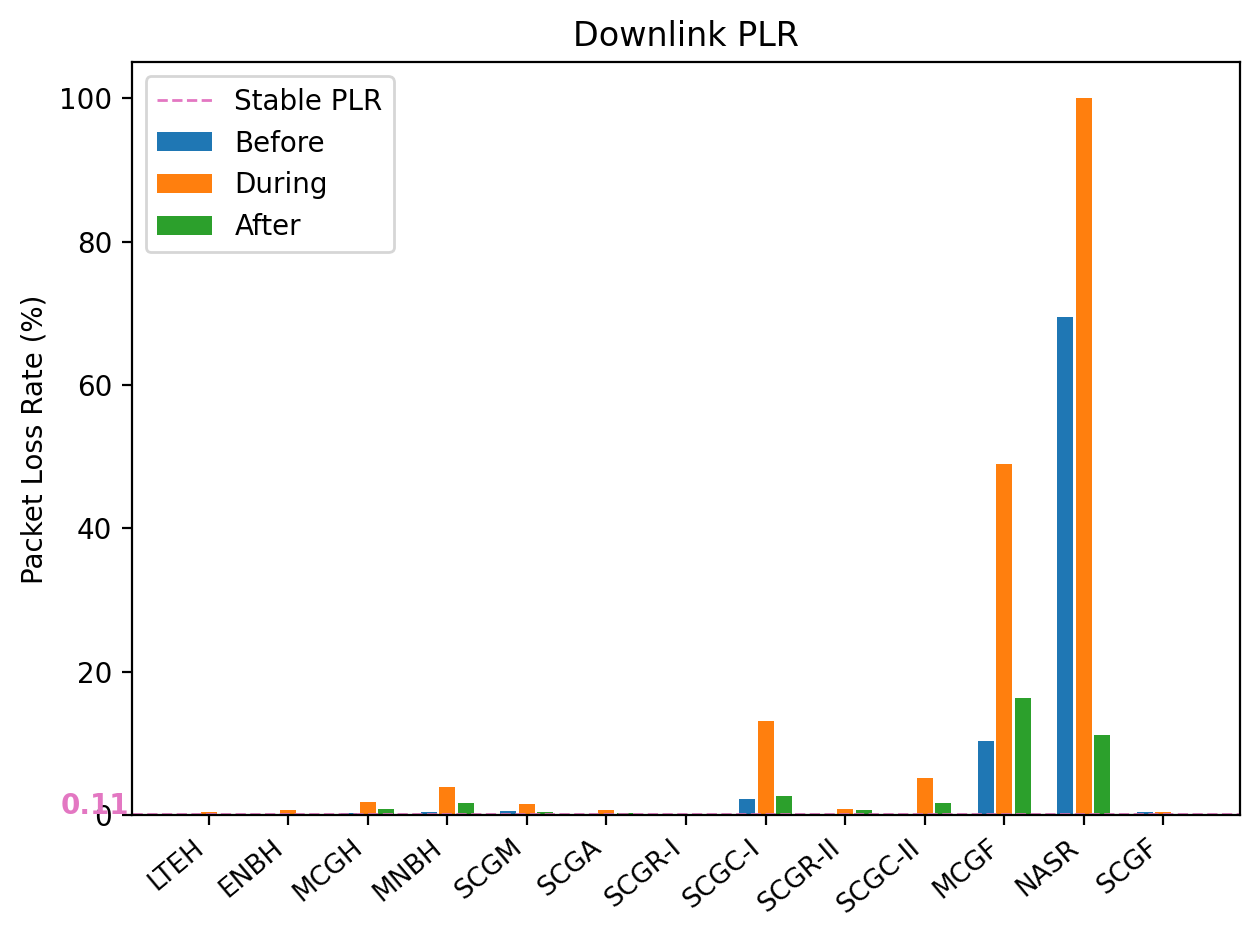

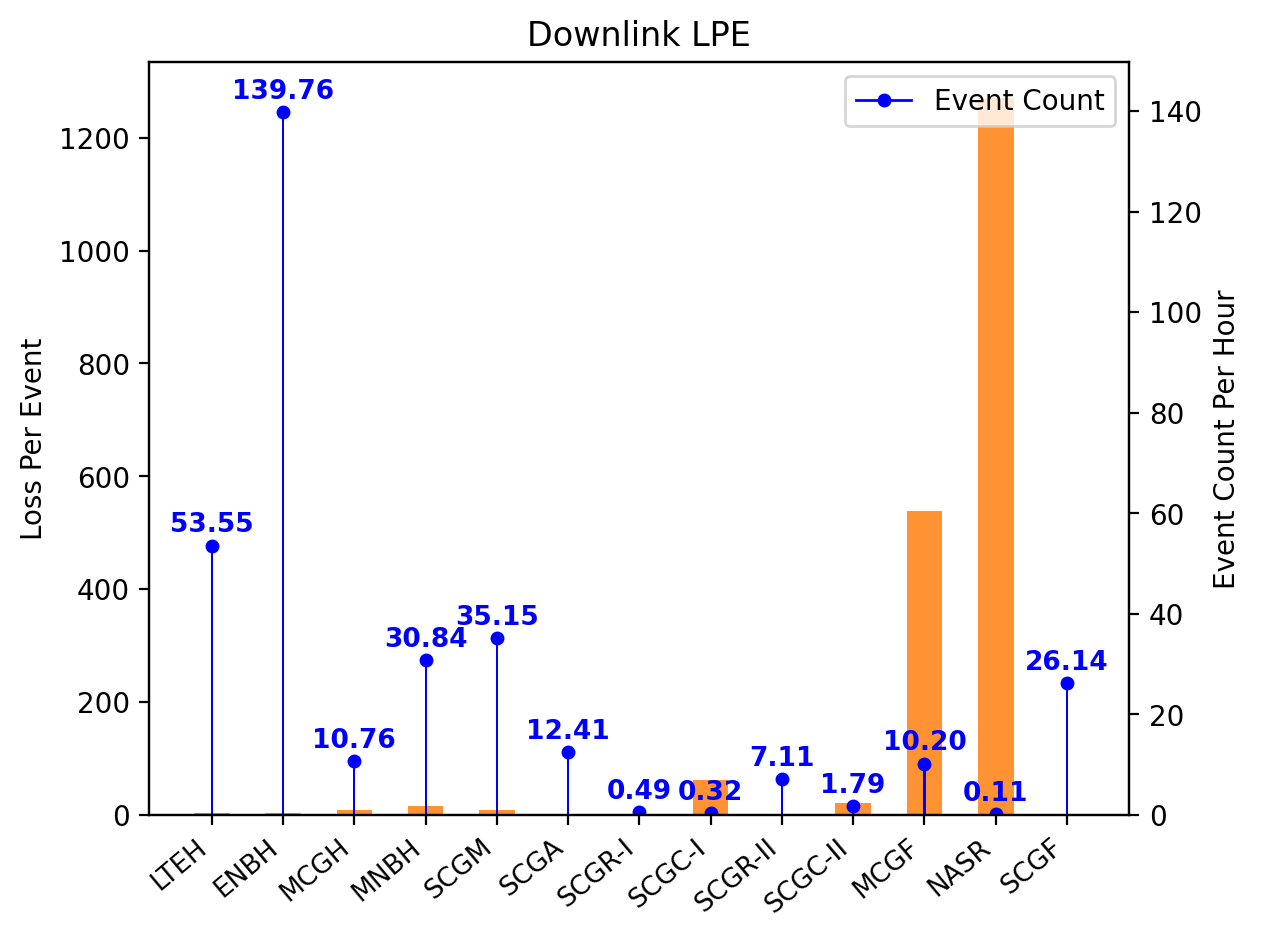

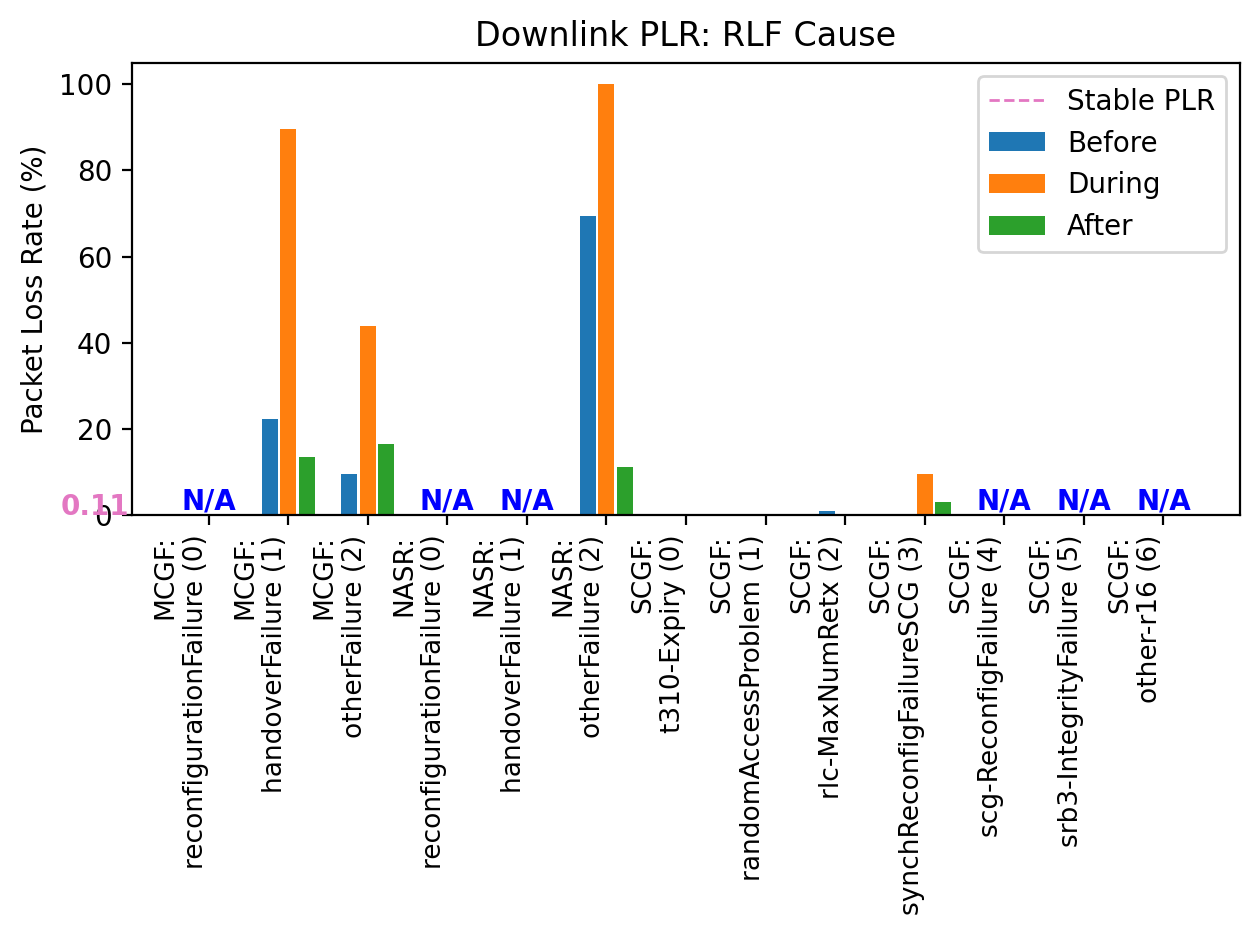

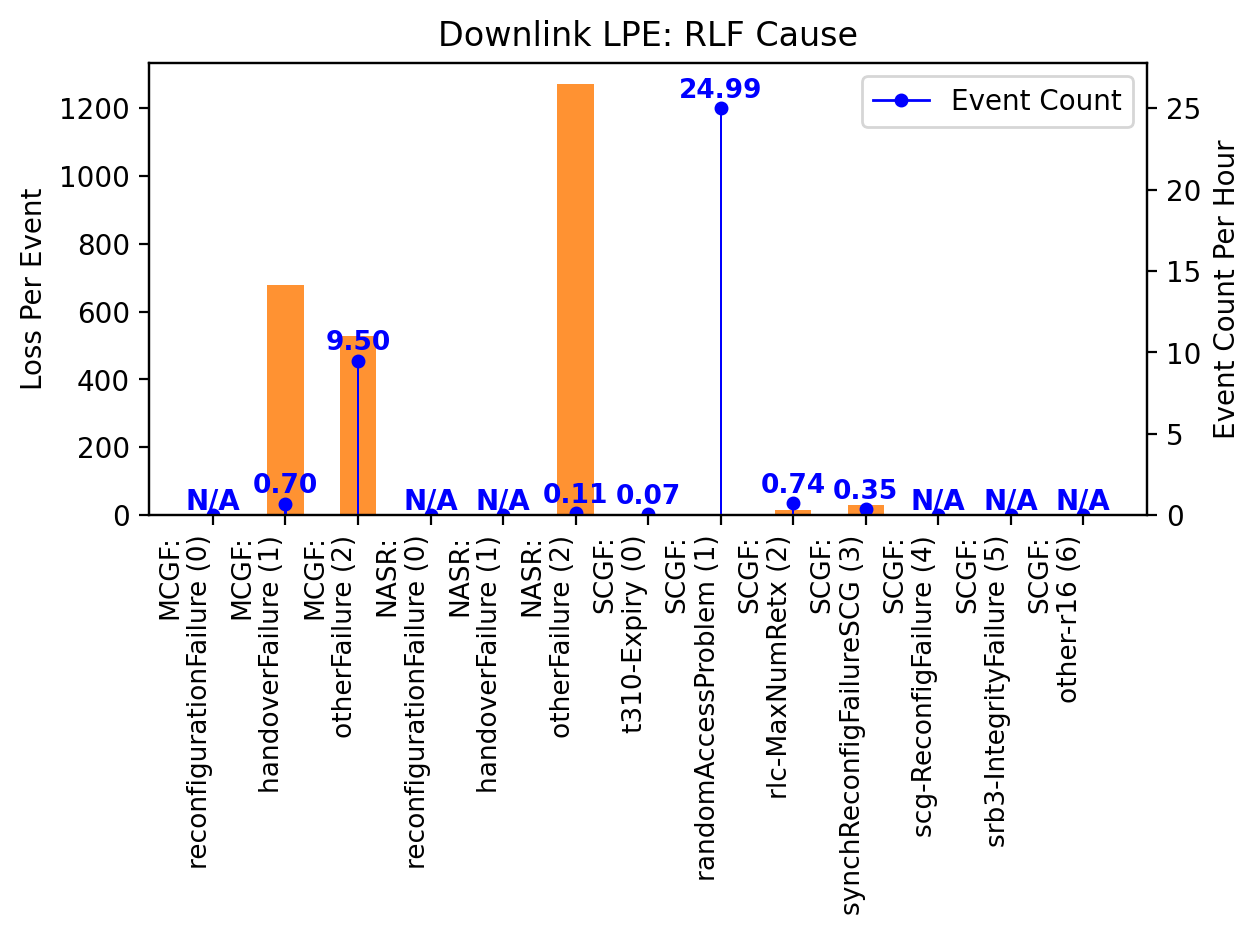

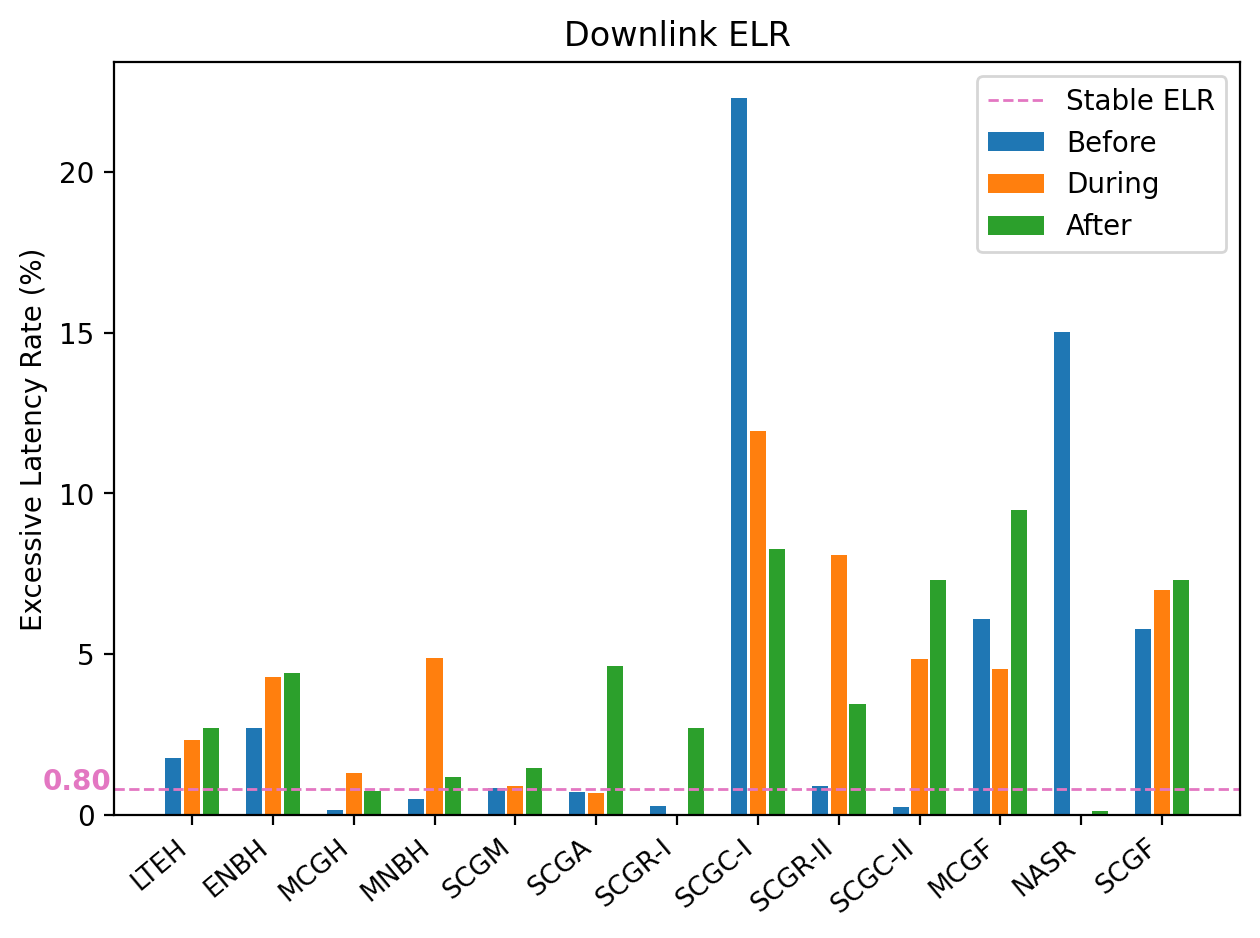

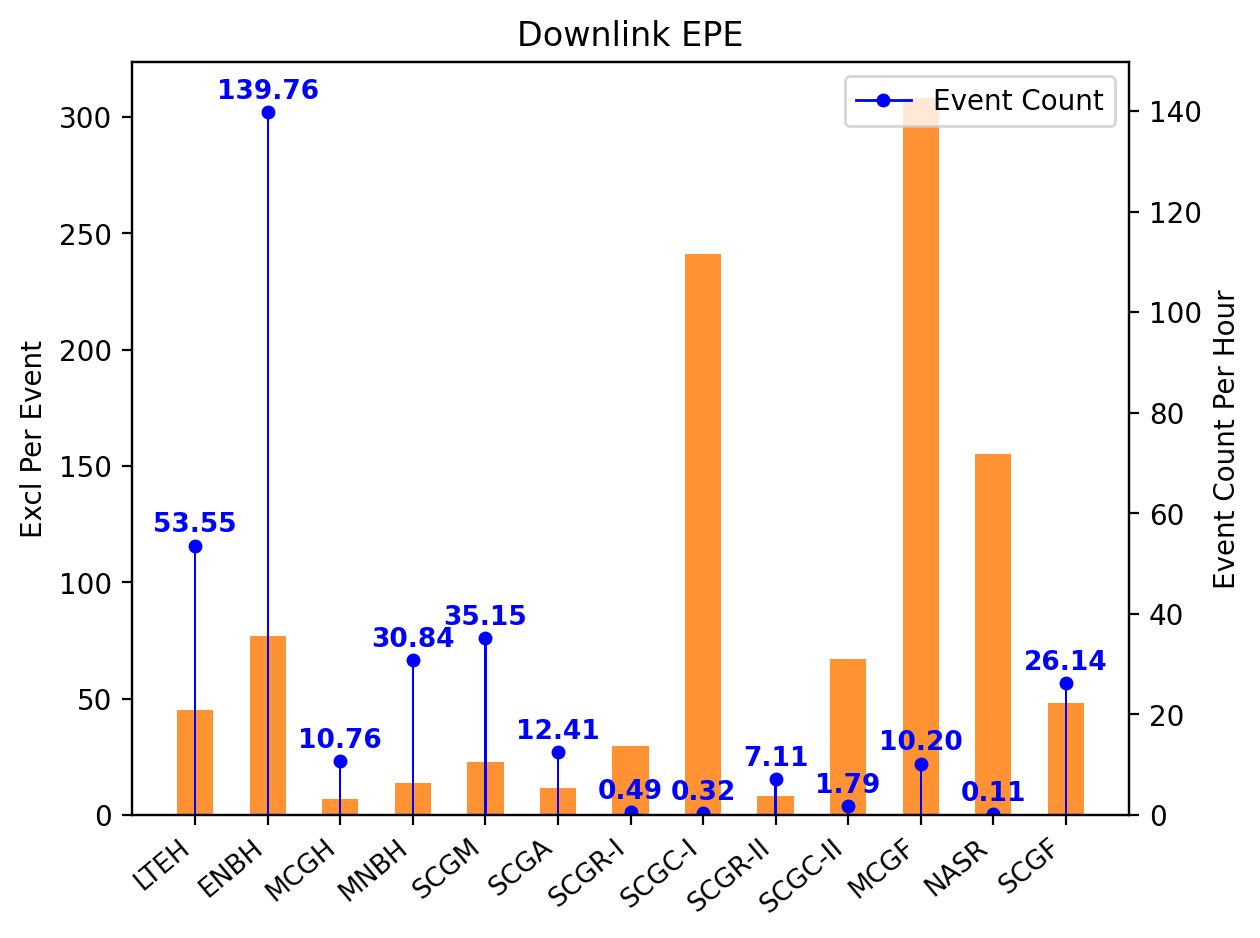

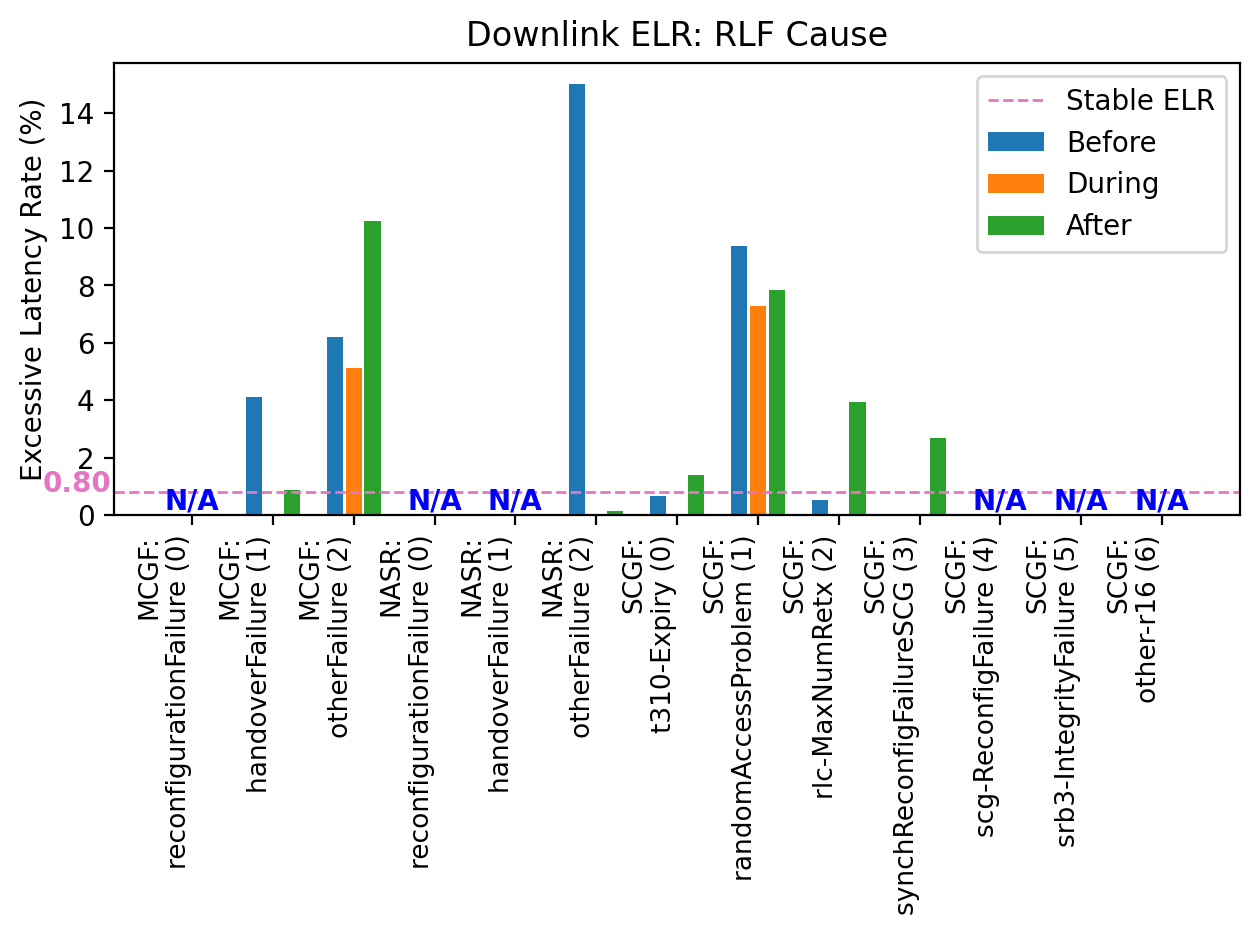

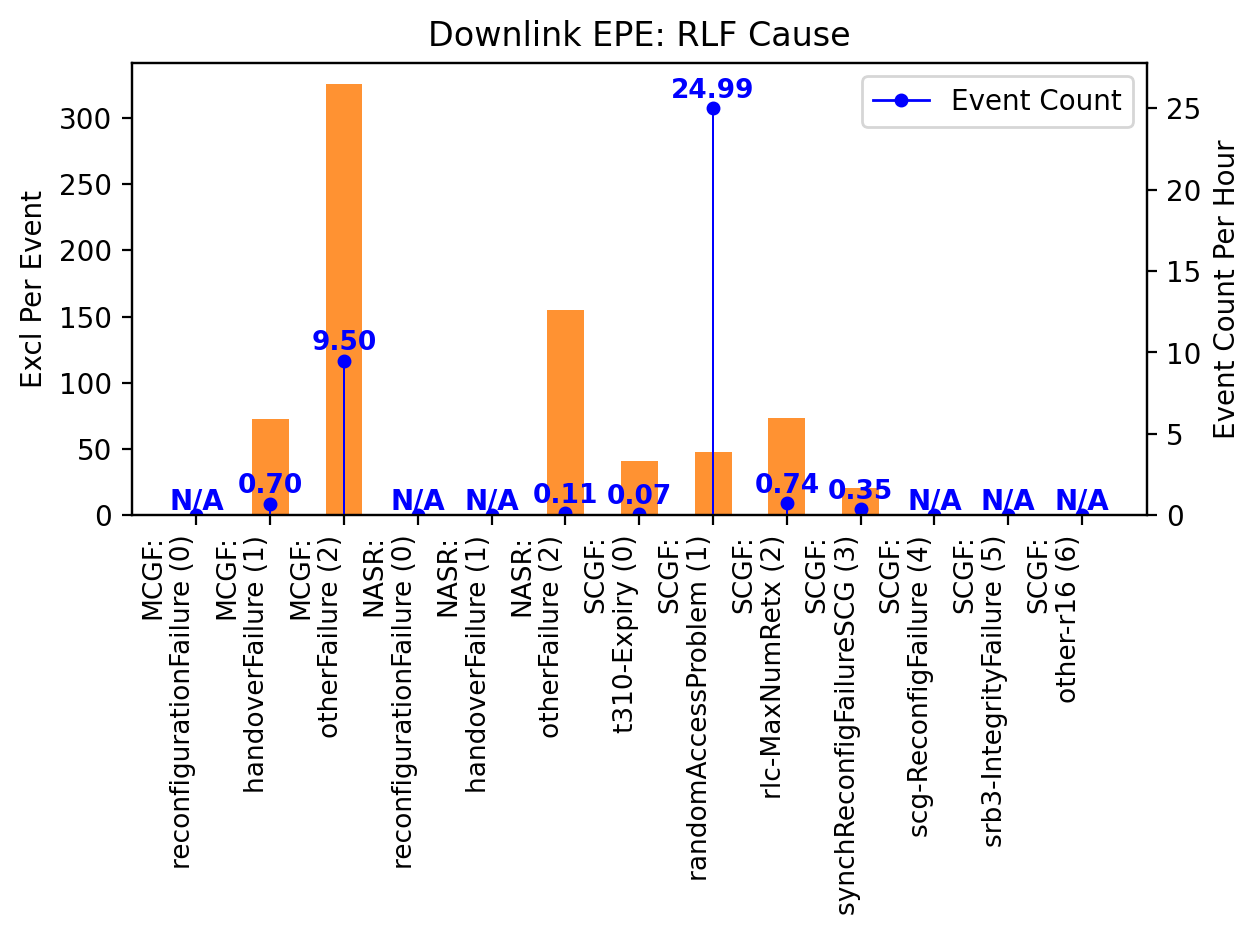

In [383]:
# ****************************************** PLR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** PLR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()

## Green Line

In [384]:
filenames = []

root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"
date_dirs = ['2023-10-05']
date_dirs = [os.path.join(root_dir, s) for s in sorted(date_dirs)]

for date_dir in date_dirs:
    exp_dirs = [s for s in os.listdir(date_dir) if os.path.isdir(os.path.join(date_dir, s)) and s != '.DS_Store']
    exp_dirs = [os.path.join(date_dir, s) for s in sorted(exp_dirs)]
    for exp_dir in exp_dirs:
        dev_dirs = [s for s in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, s)) and s != '.DS_Store']
        dev_dirs = [os.path.join(exp_dir, s) for s in sorted(dev_dirs)]
        for dev_dir in dev_dirs:
            trip_dirs = [s for s in os.listdir(dev_dir) if os.path.isdir(os.path.join(dev_dir, s)) and s != '.DS_Store']
            trip_dirs = [os.path.join(dev_dir, s, 'data') for s in sorted(trip_dirs)]
            for trip_dir in trip_dirs:
                # print(trip_dir)
                rrc_file = [os.path.join(trip_dir, s) for s in os.listdir(trip_dir) if s.endswith('rrc.csv')][0]
                dl_file = os.path.join(trip_dir, 'udp_dnlk_loss_latency.csv')
                ul_file = os.path.join(trip_dir, 'udp_uplk_loss_latency.csv')
                # print(rrc_file, os.path.isfile(rrc_file))
                # print(dl_file, os.path.isfile(dl_file))
                # print(ul_file, os.path.isfile(ul_file))
                filenames.append((rrc_file, dl_file, ul_file))
                
pprint(filenames, sort_dicts=False)

[('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#01/data/diag_log_sm00_2023-10-05_14-24-16_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#01/data/udp_uplk_loss_latency.csv'),
 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-10-05_15-15-00_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#02/data/udp_uplk_loss_latency.csv'),
 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-10-05_14-24-16_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm01/#01/data/udp_dnlk_loss_latency.csv'

In [385]:
mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

evt_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', *mcgf,
    'NASR', *nasr,
    'SCGF', *scgf,
]

# record all traces' info in each type list
D = {tag: [] for tag in evt_types}
D['stable_mets'] = []
D['duration'] = []

Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
Stats = namedtuple('Stats', ['count', 'duration', 'metrics'])
Stage = namedtuple('Stage', ['before', 'during', 'after'])

for i, (rrc_file, dl_file, ul_file) in enumerate(filenames):
    ########### in for loop (iterating exprs) ##### start
    print(i, (rrc_file, dl_file, ul_file))
    df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)
    if df_ho.empty:
        continue
    
    df_dl = set_data(pd.read_csv(dl_file))
    df_ul = set_data(pd.read_csv(ul_file))
    E, df_dl, df_ul = handover_classify_labelling(df_ho, df_dl, df_ul)
    
    # store handover labelling to avoid parsing again and again
    df_dl.to_pickle(os.path.join(os.path.dirname(dl_file), 'udp_dnlk_loss_latency_ho.pkl'))
    df_ul.to_pickle(os.path.join(os.path.dirname(ul_file), 'udp_uplk_loss_latency_ho.pkl'))
    with open(os.path.join(os.path.dirname(rrc_file), 'single_radio_ho_stats.pkl'), 'wb') as f:
        pickle.dump(metrics_duration_into_dict(E), f)

    for tag in evt_types:
        # print(tag)
        infos = []
        for i, stage in enumerate(['before', 'during', 'after']):
            # count
            count = len(E[stage][tag])
            # duration
            duration = 0
            intv_list = [item[0] for item in E[stage][tag]]
            for intv in intv_list:
                if intv.empty:
                    continue
                duration += (intv.upper - intv.lower).total_seconds()
            # metrics
            mets_list = [item[1] for item in E[stage][tag]]
            metrics = Metrics(sum([item.dl_pkt for item in mets_list]), sum([item.dl_lost for item in mets_list]), sum([item.dl_excl for item in mets_list]), sum([item.ul_pkt for item in mets_list]), sum([item.ul_lost for item in mets_list]), sum([item.ul_excl for item in mets_list]))
            
            # print(stage, count, duration, metrics)
            infos.append(Stats(count, duration, metrics))
        D[tag].append(Stage(*infos))
        
    D['stable_mets'].append(E['overview']['stable_intv'][1])
    D['duration'].append(E['overview']['duration'])
    ########### in for loop (iterating exprs) ##### end

# pprint(D, sort_dicts=False)

0 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#01/data/diag_log_sm00_2023-10-05_14-24-16_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#01/data/udp_uplk_loss_latency.csv')
{3050: 7.0}
1 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-10-05_15-15-00_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm00/#02/data/udp_uplk_loss_latency.csv')
{3050: 7.0, 1400: 3.0, 3650: 8.0}
2 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-10-05_14-24-16_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-05/Bandlock_UDP_9_Phone/sm0

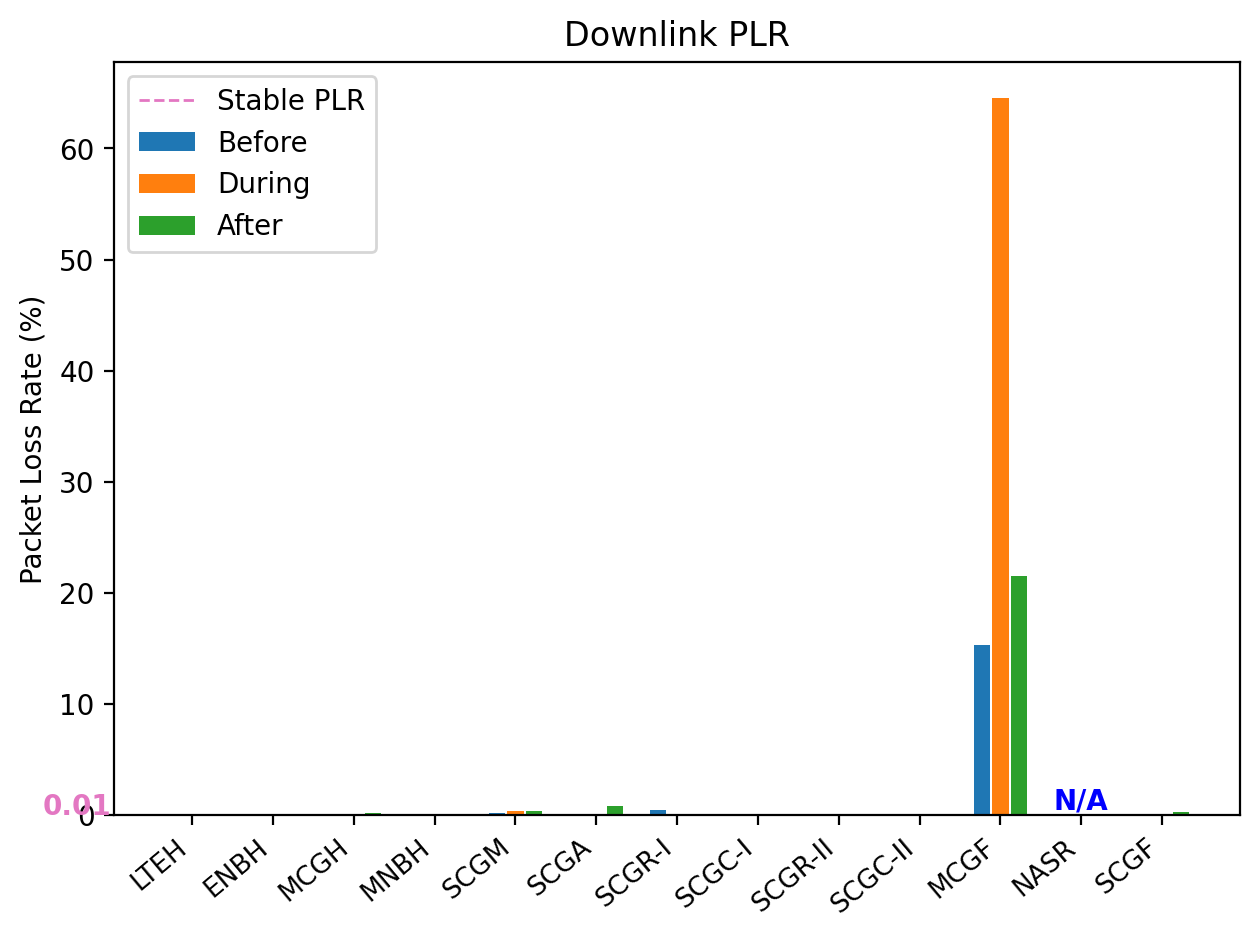

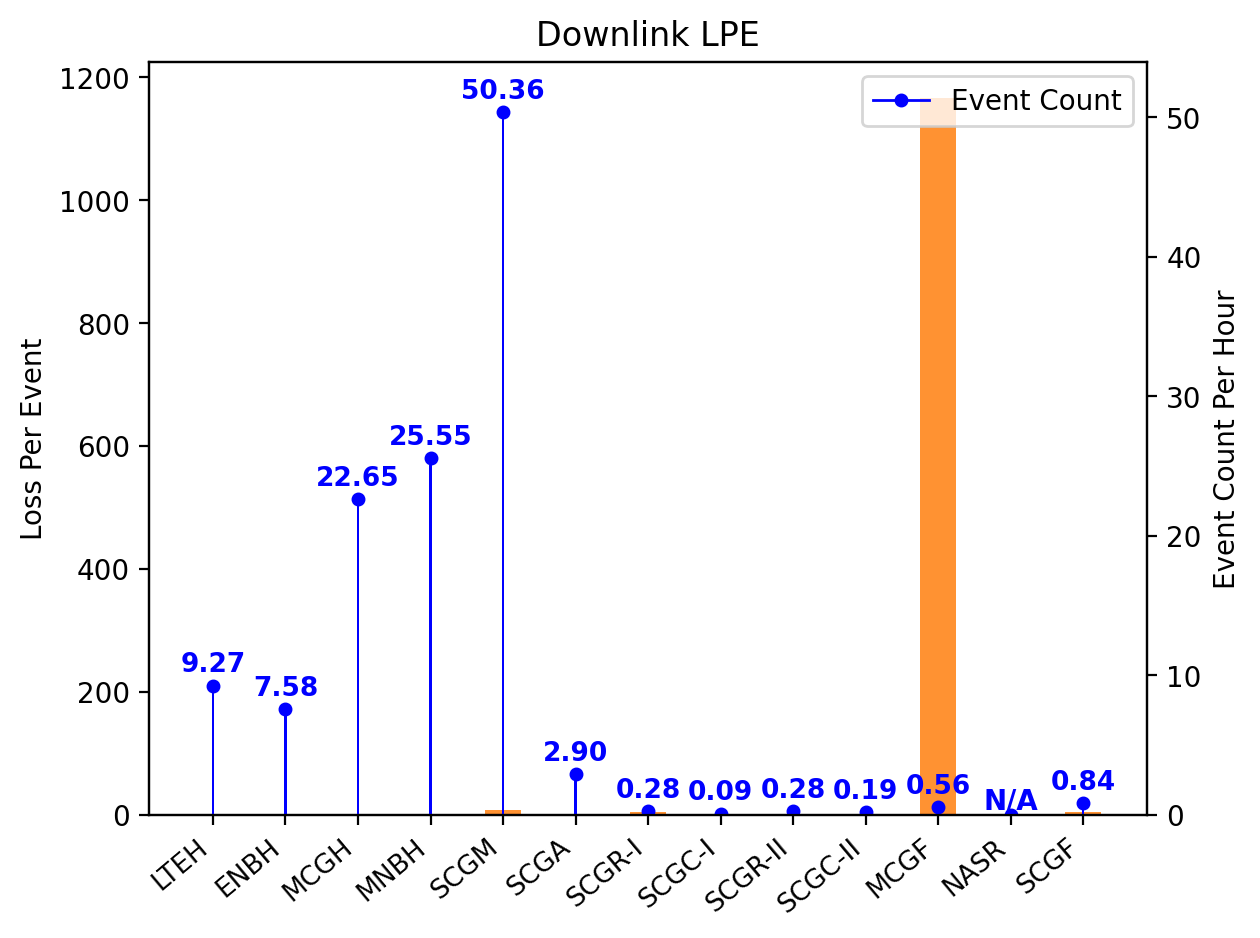

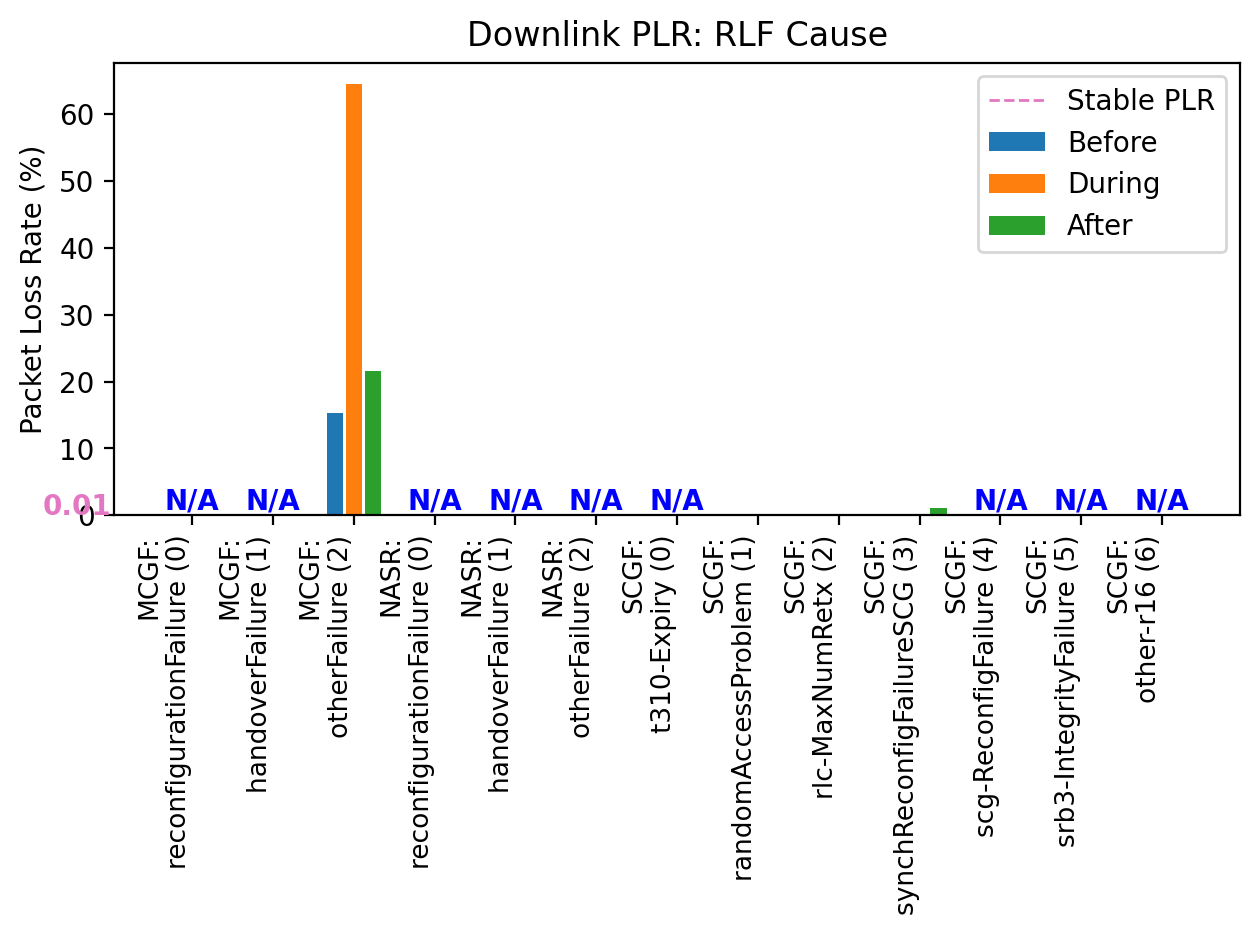

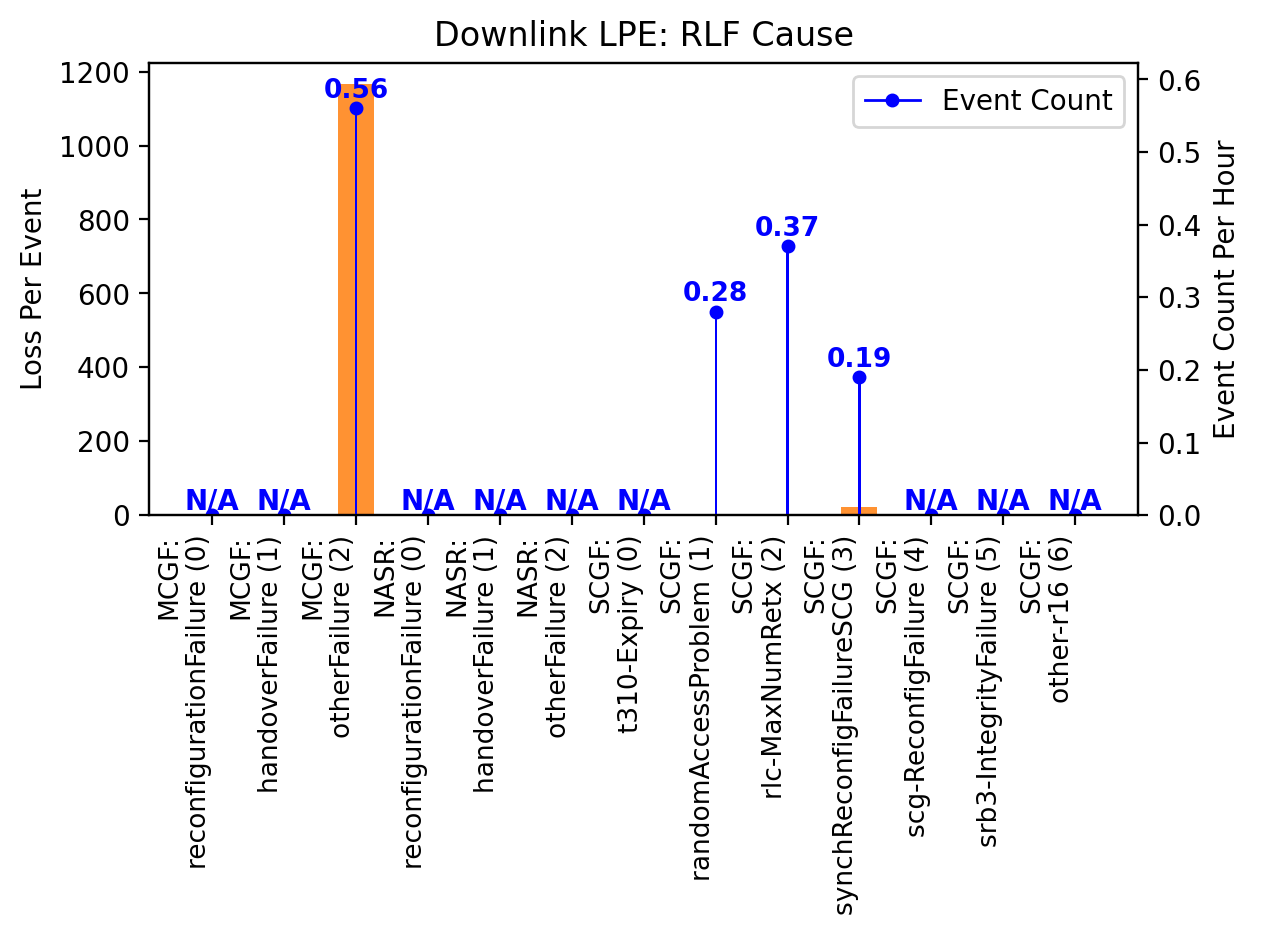

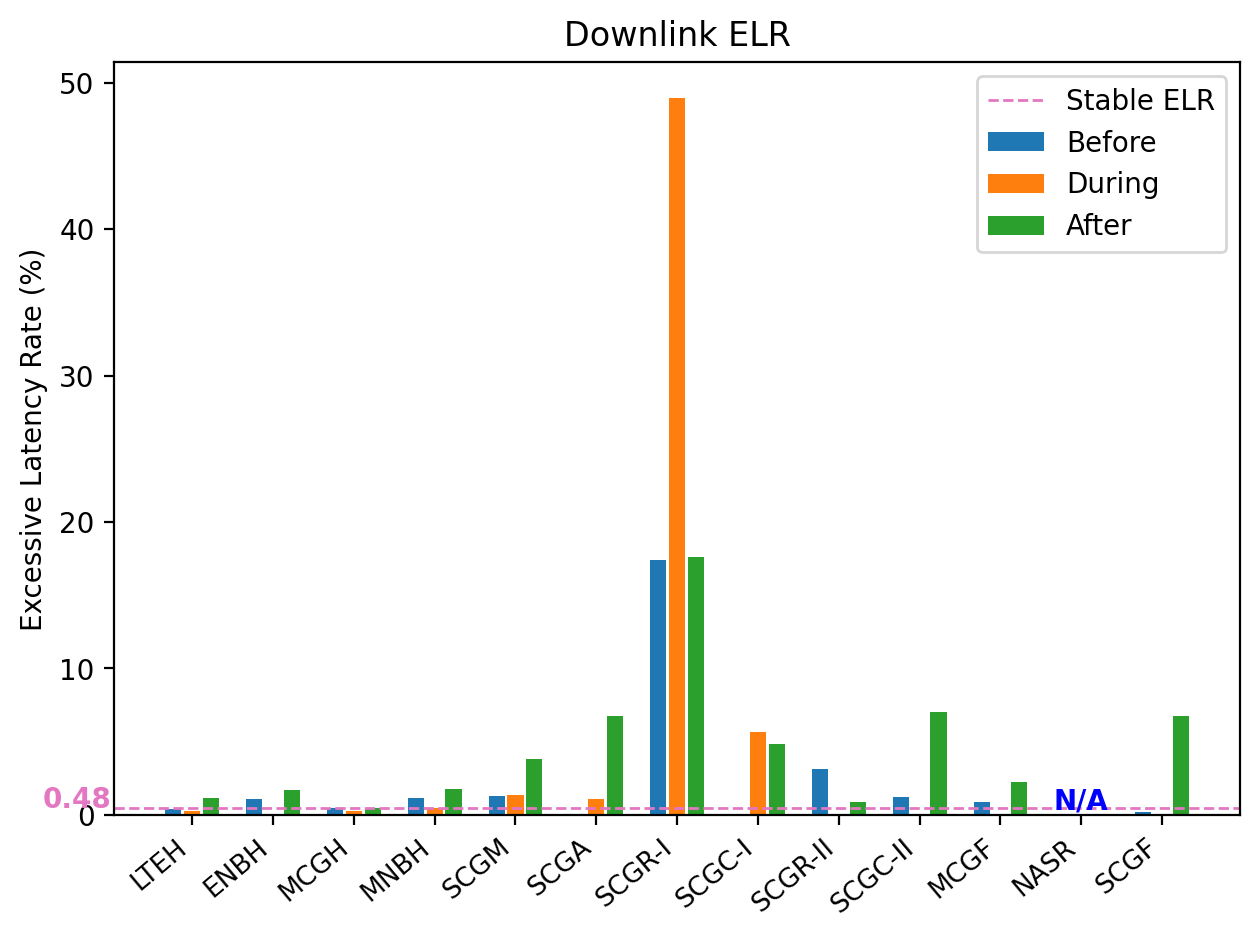

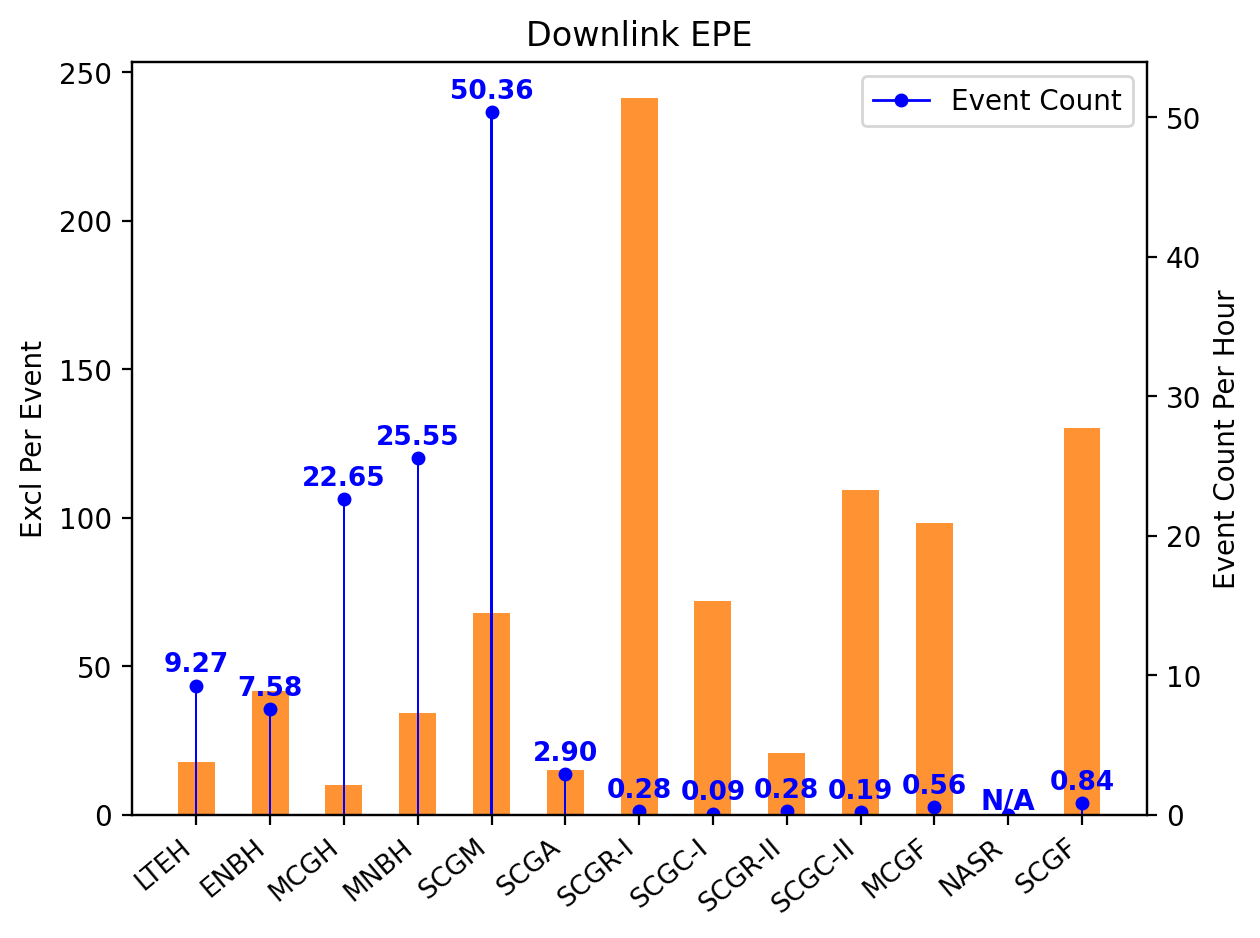

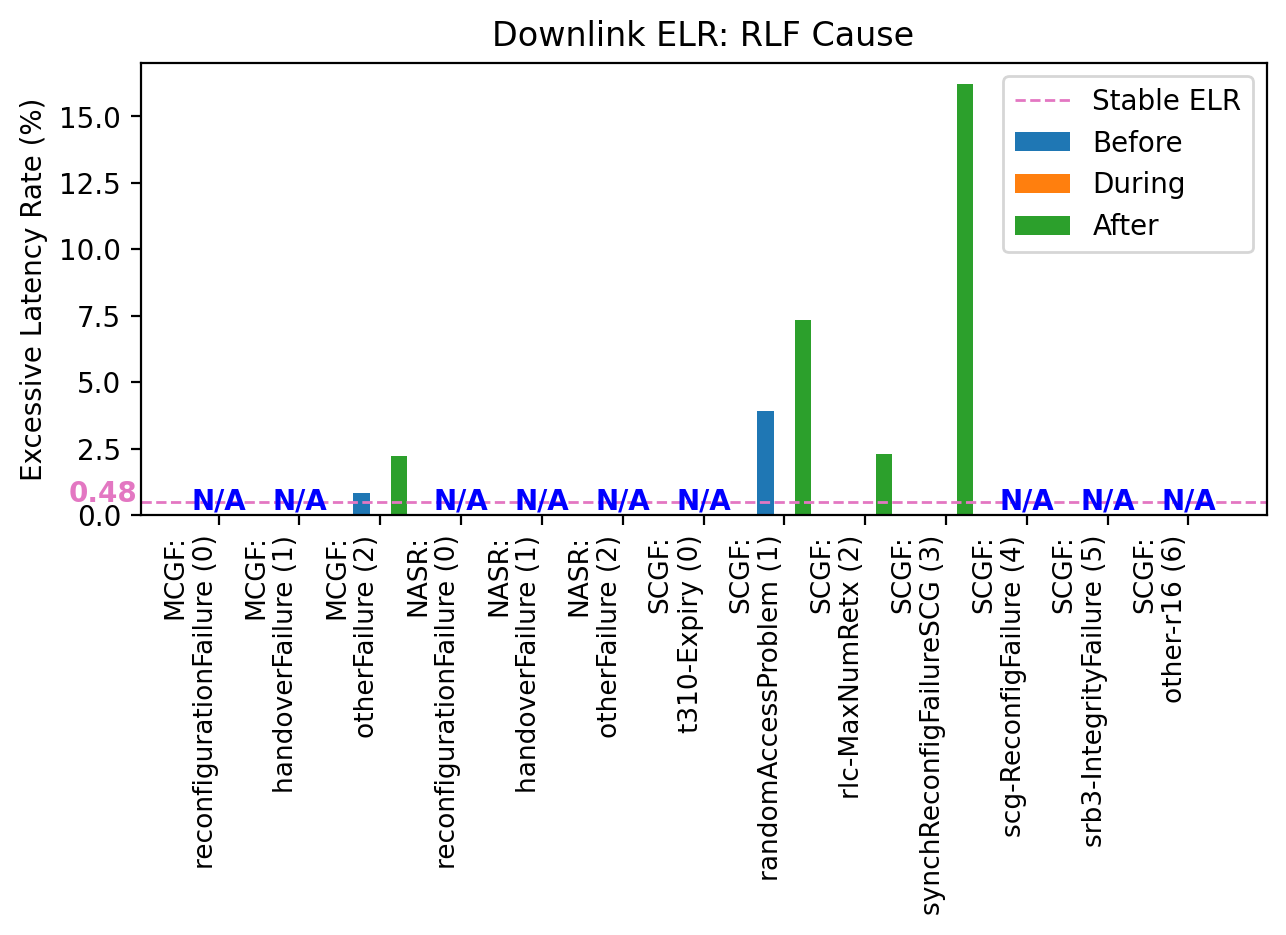

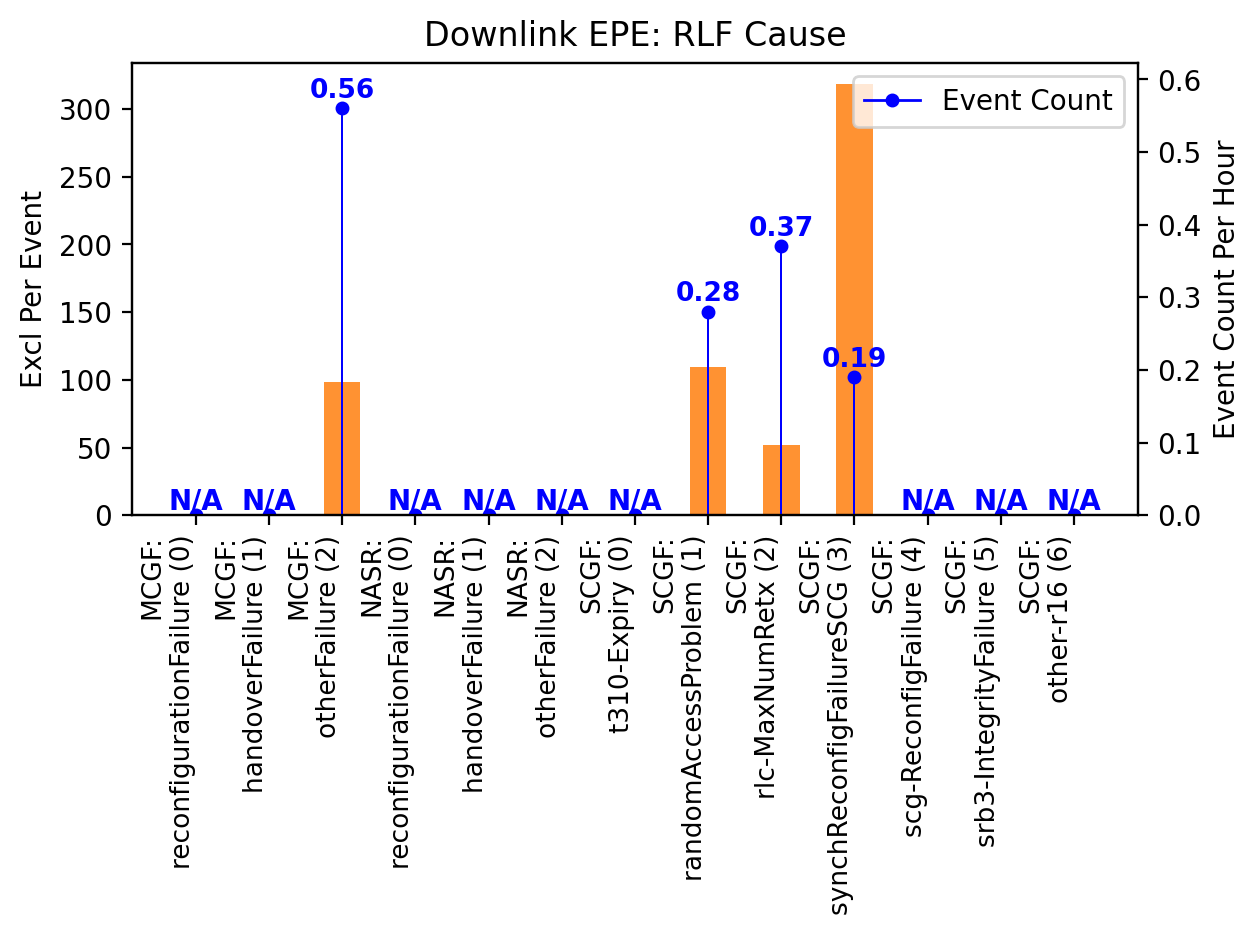

In [386]:
# ****************************************** PLR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** PLR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()

## Red Line

In [387]:
filenames = []

root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"
date_dirs = ['2023-10-19']
date_dirs = [os.path.join(root_dir, s) for s in sorted(date_dirs)]

for date_dir in date_dirs:
    exp_dirs = [s for s in os.listdir(date_dir) if os.path.isdir(os.path.join(date_dir, s)) and s != '.DS_Store']
    exp_dirs = [os.path.join(date_dir, s) for s in sorted(exp_dirs)]
    for exp_dir in exp_dirs:
        dev_dirs = [s for s in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, s)) and s != '.DS_Store']
        dev_dirs = [os.path.join(exp_dir, s) for s in sorted(dev_dirs)]
        for dev_dir in dev_dirs:
            trip_dirs = [s for s in os.listdir(dev_dir) if os.path.isdir(os.path.join(dev_dir, s)) and s != '.DS_Store']
            trip_dirs = [os.path.join(dev_dir, s, 'data') for s in sorted(trip_dirs)]
            for trip_dir in trip_dirs:
                # print(trip_dir)
                rrc_file = [os.path.join(trip_dir, s) for s in os.listdir(trip_dir) if s.endswith('rrc.csv')][0]
                dl_file = os.path.join(trip_dir, 'udp_dnlk_loss_latency.csv')
                ul_file = os.path.join(trip_dir, 'udp_uplk_loss_latency.csv')
                # print(rrc_file, os.path.isfile(rrc_file))
                # print(dl_file, os.path.isfile(dl_file))
                # print(ul_file, os.path.isfile(ul_file))
                filenames.append((rrc_file, dl_file, ul_file))
                
pprint(filenames, sort_dicts=False)

[('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#01/data/diag_log_sm00_2023-10-19_14-37-09_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#01/data/udp_uplk_loss_latency.csv'),
 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-10-19_15-54-22_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#02/data/udp_uplk_loss_latency.csv'),
 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-10-19_14-37-10_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm01/#01/data/udp_dnlk_loss_latency.csv'

In [388]:
mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]

evt_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', *mcgf,
    'NASR', *nasr,
    'SCGF', *scgf,
]

# record all traces' info in each type list
D = {tag: [] for tag in evt_types}
D['stable_mets'] = []
D['duration'] = []

Metrics = namedtuple('Metrics', ['dl_pkt', 'dl_lost', 'dl_excl', 'ul_pkt', 'ul_lost', 'ul_excl'])
Stats = namedtuple('Stats', ['count', 'duration', 'metrics'])
Stage = namedtuple('Stage', ['before', 'during', 'after'])

for i, (rrc_file, dl_file, ul_file) in enumerate(filenames):
    ########### in for loop (iterating exprs) ##### start
    print(i, (rrc_file, dl_file, ul_file))
    df_ho, _ = mi_parse_handover(pd.read_csv(rrc_file), radical=True)
    if df_ho.empty:
        continue
    
    df_dl = set_data(pd.read_csv(dl_file))
    df_ul = set_data(pd.read_csv(ul_file))
    E, df_dl, df_ul = handover_classify_labelling(df_ho, df_dl, df_ul)
    
    # store handover labelling to avoid parsing again and again
    df_dl.to_pickle(os.path.join(os.path.dirname(dl_file), 'udp_dnlk_loss_latency_ho.pkl'))
    df_ul.to_pickle(os.path.join(os.path.dirname(ul_file), 'udp_uplk_loss_latency_ho.pkl'))
    with open(os.path.join(os.path.dirname(rrc_file), 'single_radio_ho_stats.pkl'), 'wb') as f:
        pickle.dump(metrics_duration_into_dict(E), f)

    for tag in evt_types:
        # print(tag)
        infos = []
        for i, stage in enumerate(['before', 'during', 'after']):
            # count
            count = len(E[stage][tag])
            # duration
            duration = 0
            intv_list = [item[0] for item in E[stage][tag]]
            for intv in intv_list:
                if intv.empty:
                    continue
                duration += (intv.upper - intv.lower).total_seconds()
            # metrics
            mets_list = [item[1] for item in E[stage][tag]]
            metrics = Metrics(sum([item.dl_pkt for item in mets_list]), sum([item.dl_lost for item in mets_list]), sum([item.dl_excl for item in mets_list]), sum([item.ul_pkt for item in mets_list]), sum([item.ul_lost for item in mets_list]), sum([item.ul_excl for item in mets_list]))
            
            # print(stage, count, duration, metrics)
            infos.append(Stats(count, duration, metrics))
        D[tag].append(Stage(*infos))
        
    D['stable_mets'].append(E['overview']['stable_intv'][1])
    D['duration'].append(E['overview']['duration'])
    ########### in for loop (iterating exprs) ##### end

# pprint(D, sort_dicts=False)

0 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#01/data/diag_log_sm00_2023-10-19_14-37-09_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#01/data/udp_uplk_loss_latency.csv')
{3050: 7.0, 1750: 3.0, 1400: 3.0, 3650: 8.0}
1 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#02/data/diag_log_sm00_2023-10-19_15-54-22_rrc.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv', '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm00/#02/data/udp_uplk_loss_latency.csv')
{3050: 7.0, 1750: 3.0, 1400: 3.0, 3650: 8.0}
2 ('/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-19/Bandlock_UDP_9_Phone/sm01/#01/data/diag_log_sm01_2023-10-19_14-37-10_rrc.csv', '/Users/jackbedford/Desktop/MOXA/C

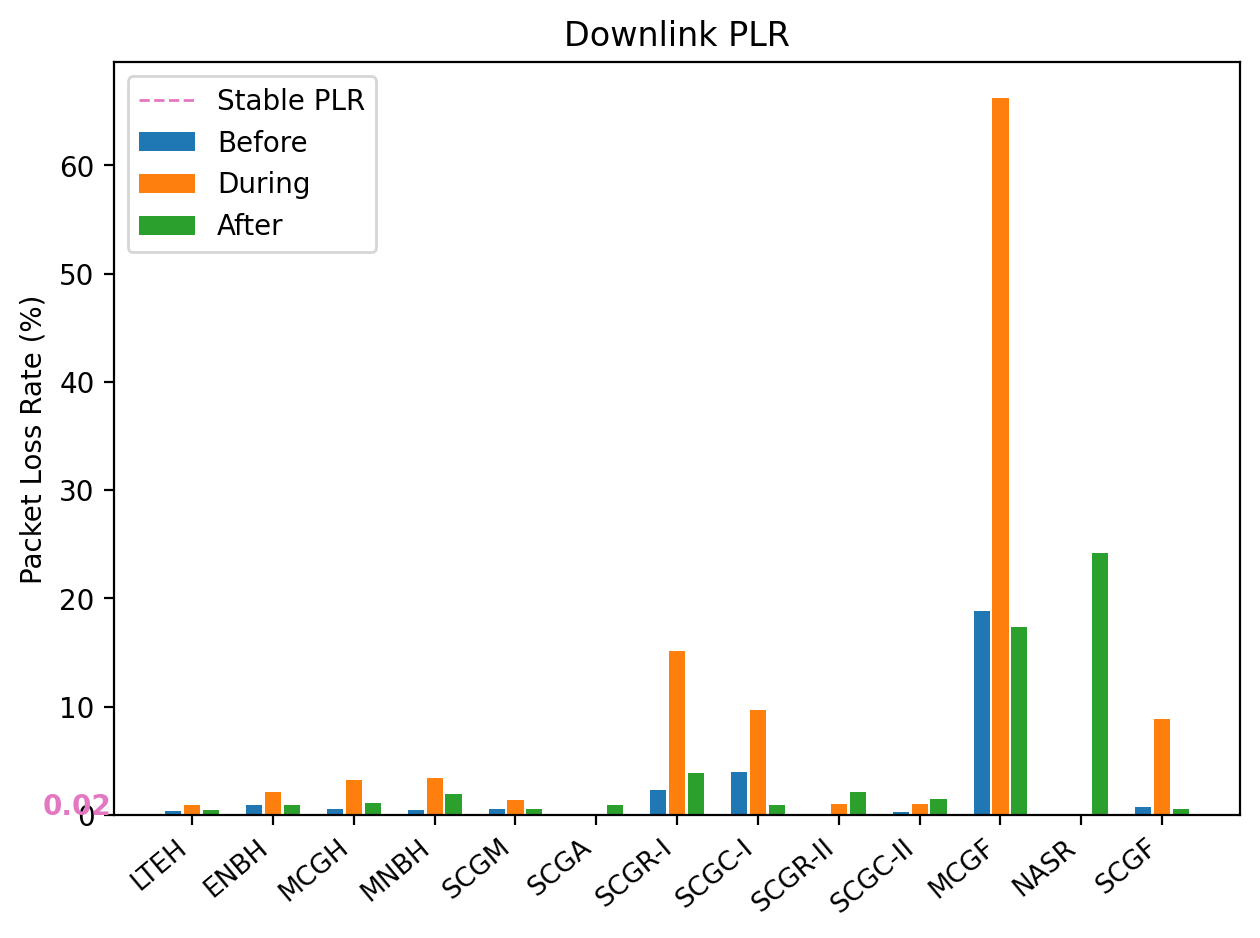

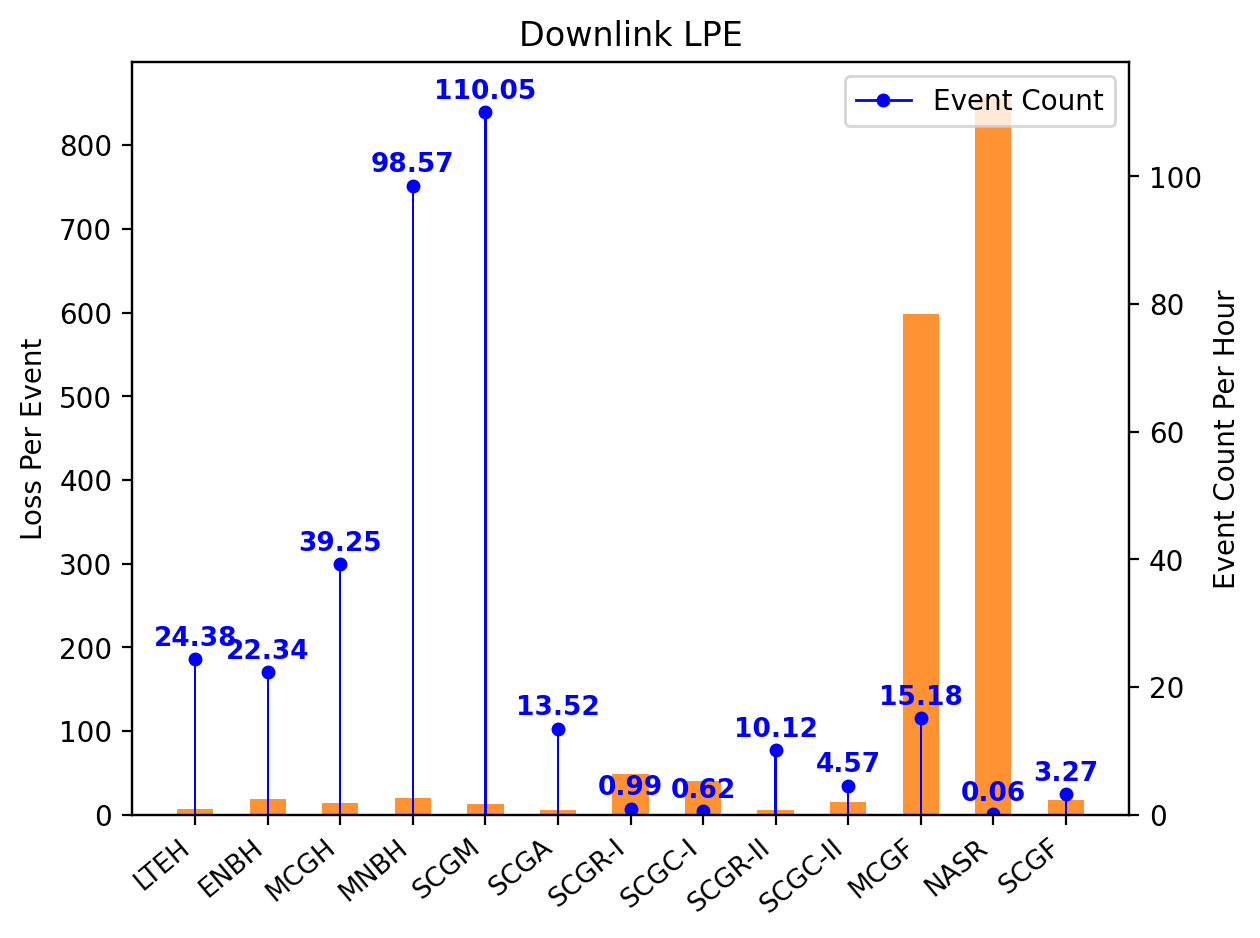

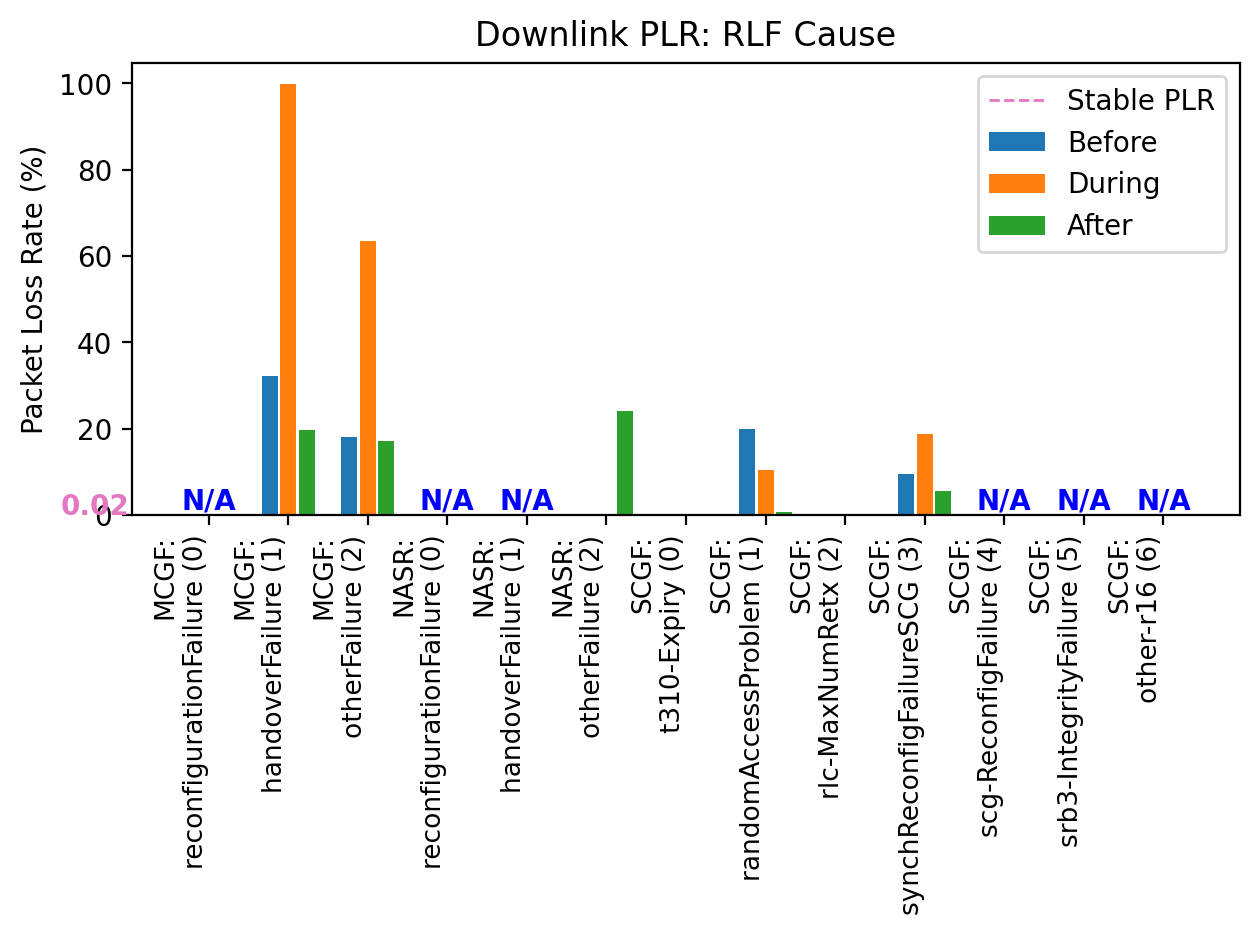

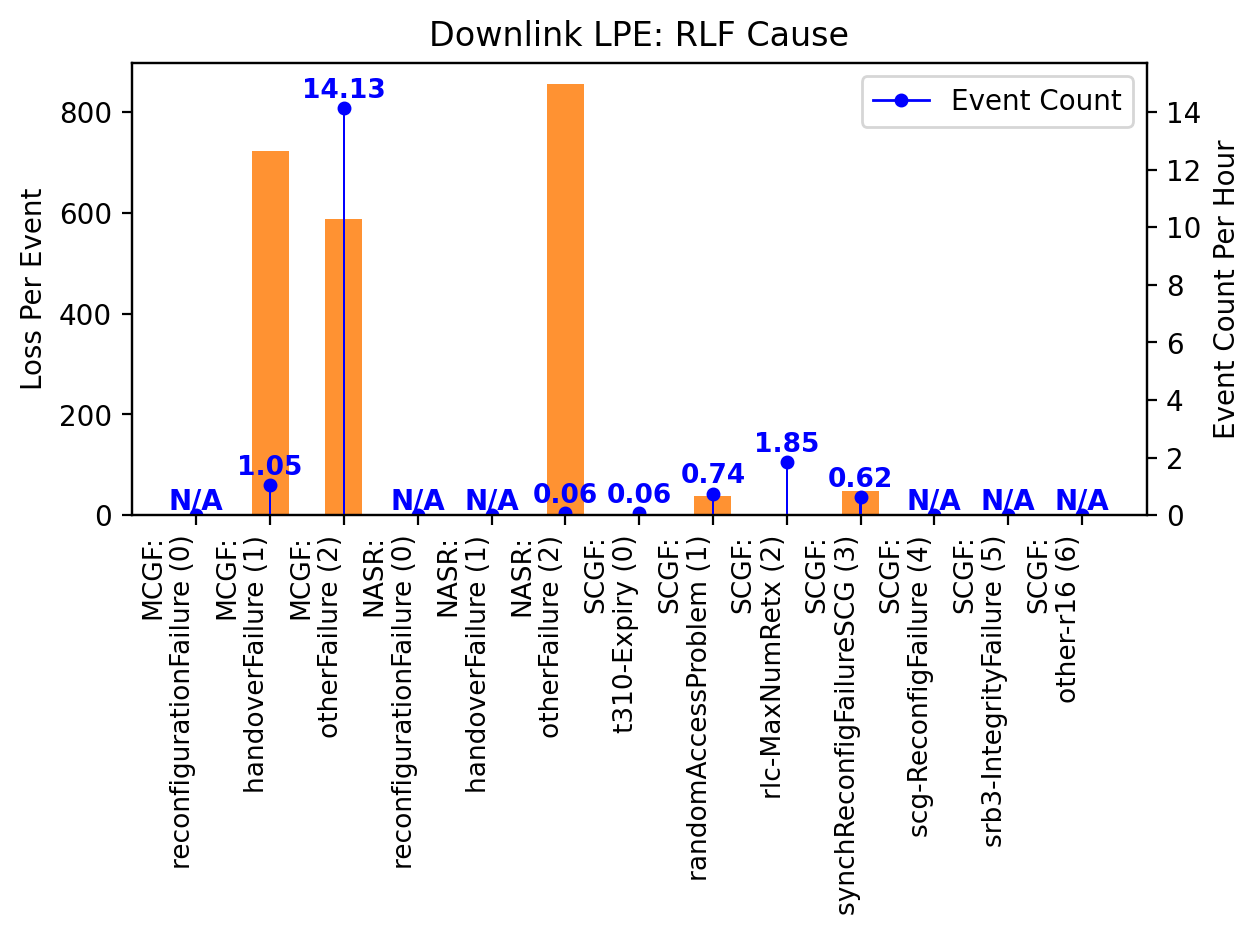

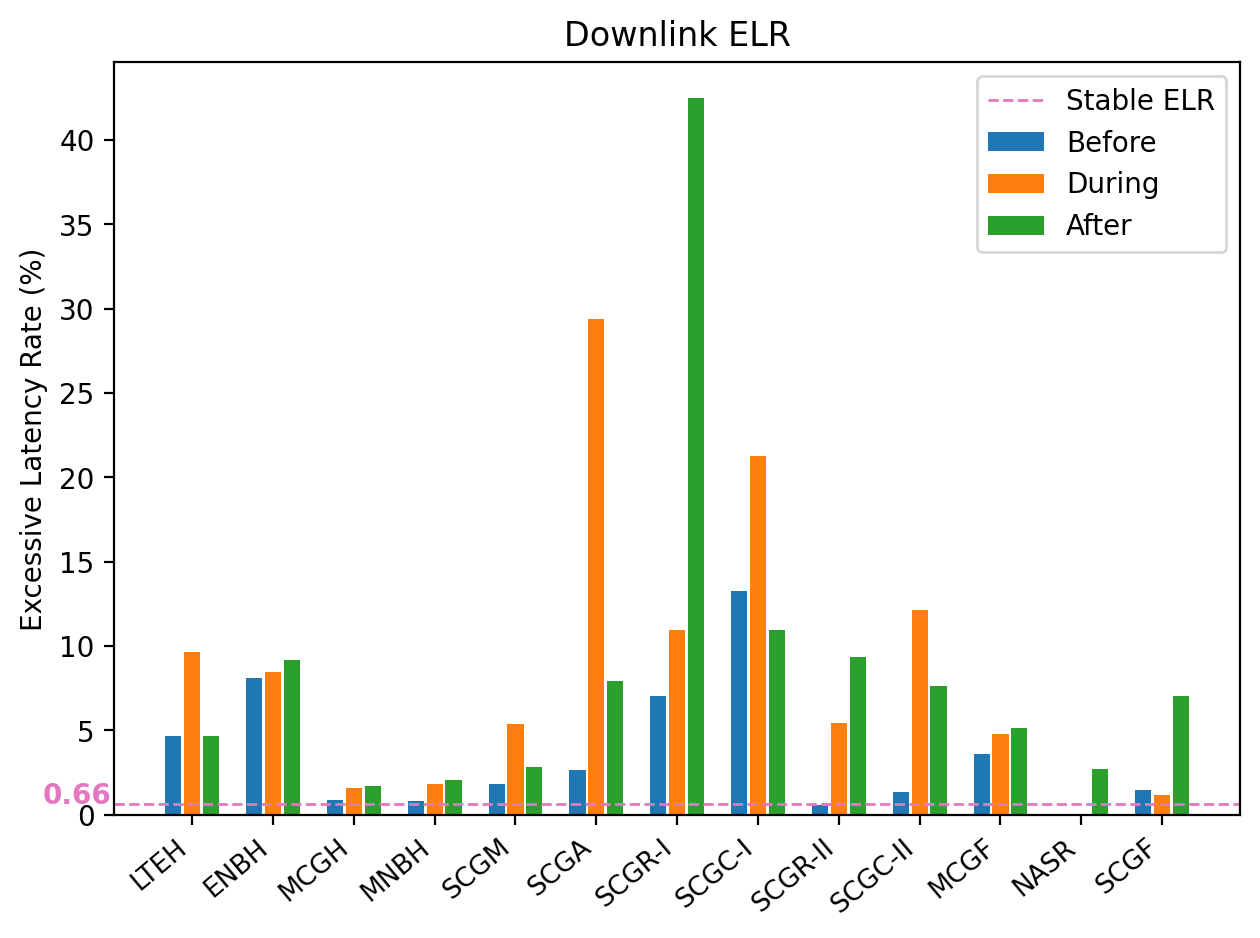

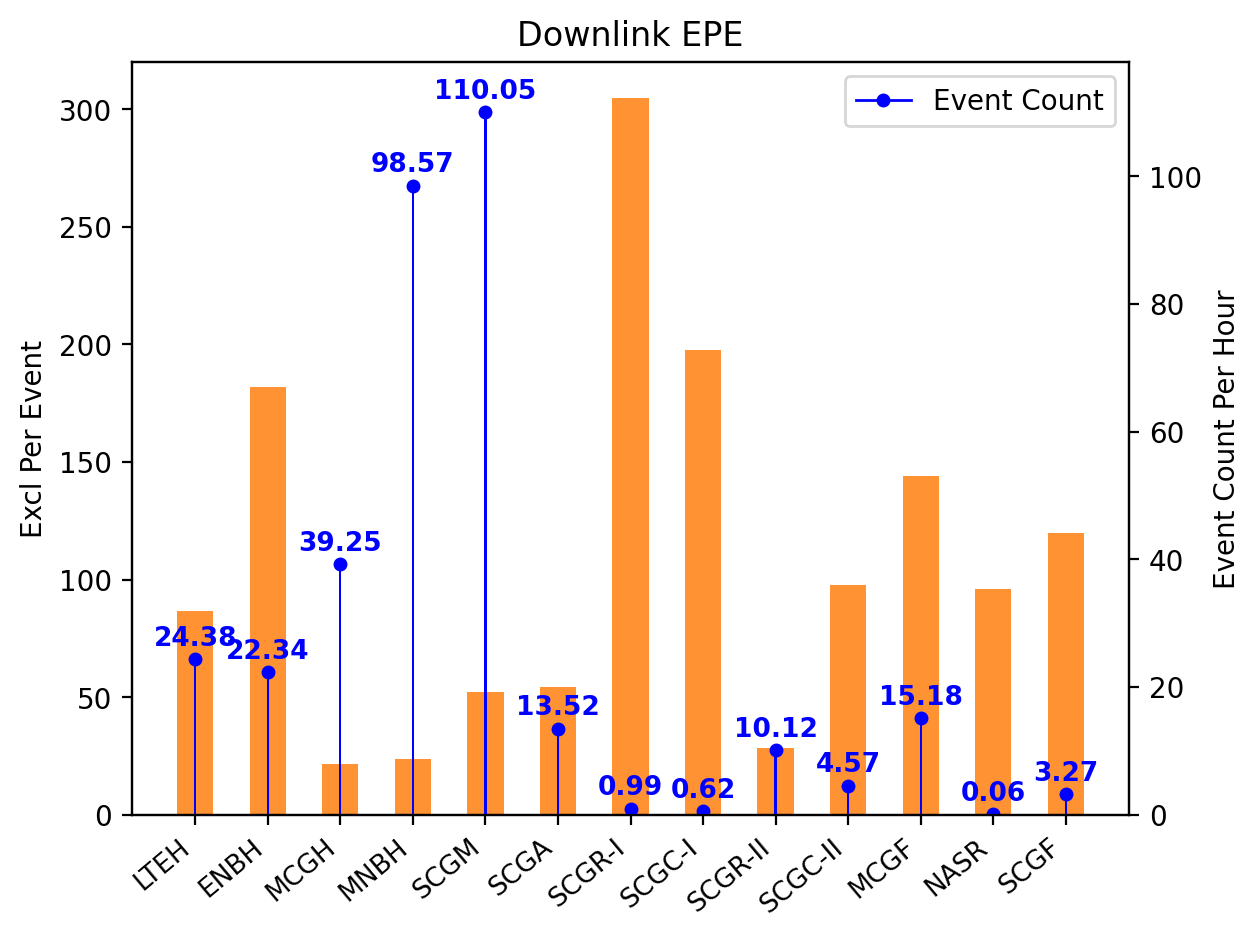

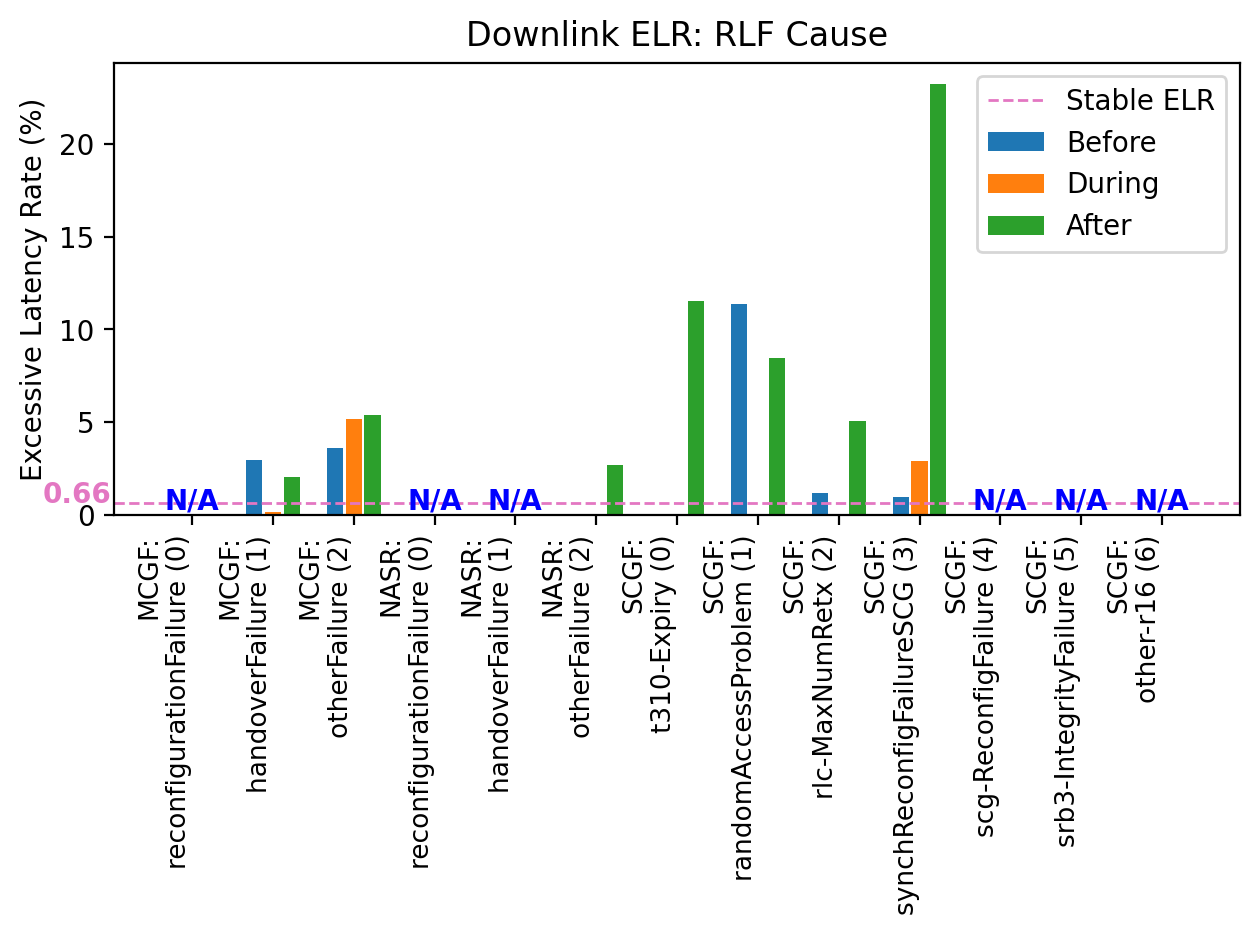

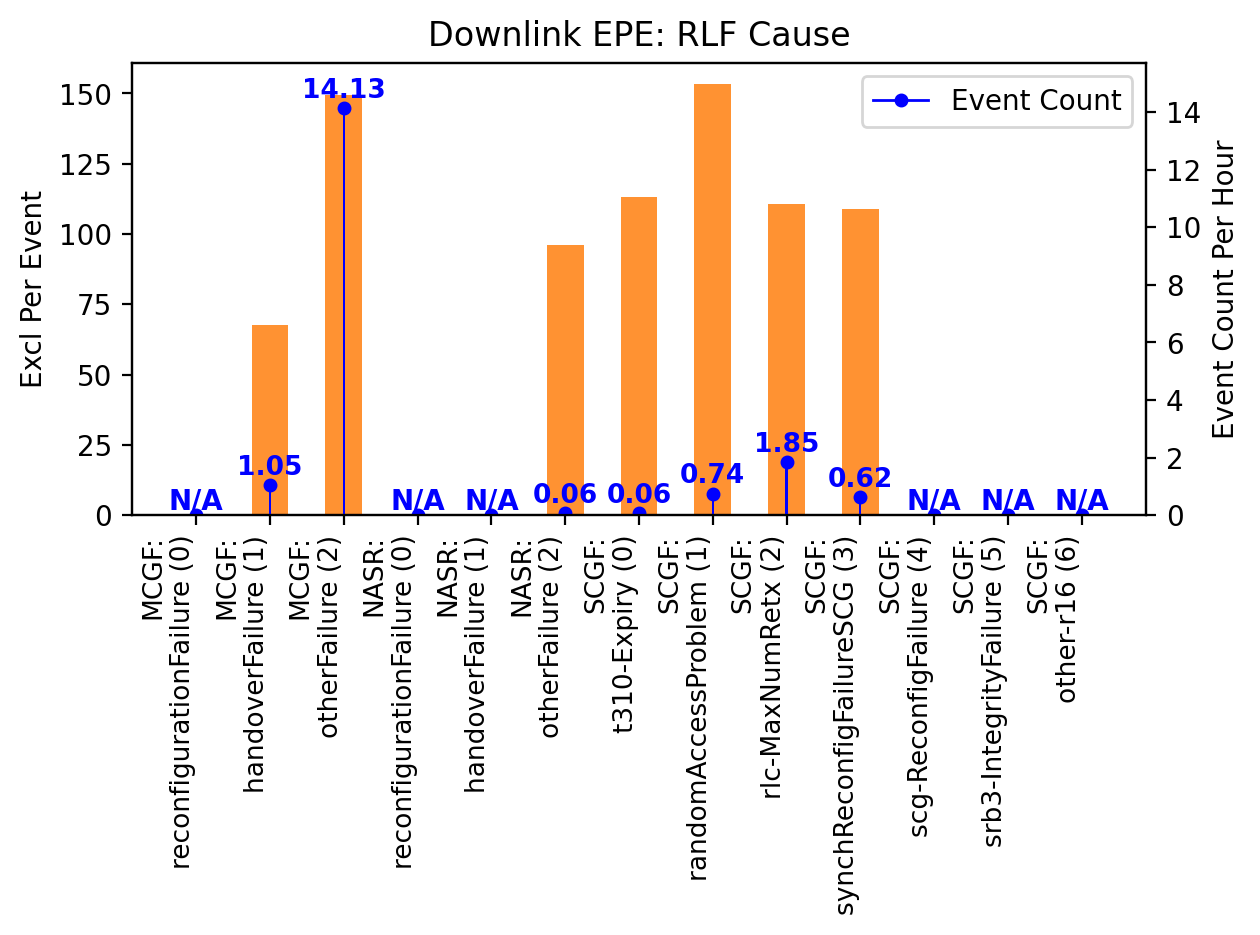

In [389]:
# ****************************************** PLR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** PLR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_loss_rate = [round(sum([item.before.metrics.dl_lost for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_loss_rate = [round(sum([item.during.metrics.dl_lost for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_loss_rate = [round(sum([item.after.metrics.dl_lost for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_loss_rate = round(sum([item.dl_lost for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_loss_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_loss_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_loss_rate, width, label='After')
ax.axhline(stable_loss_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable PLR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_loss_rate, '{:.2f}'.format(stable_loss_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink PLR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** LPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
loss_per_event = [round(sum([sum([item[k].metrics.dl_lost for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, loss_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss Per Event')
ax.set_title('Downlink LPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR')
ax.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE ******************************************

ho_types = [
    'LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II',
    'MCGF', 'NASR', 'SCGF',
]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.02)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE')
ax_twin.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** ELR (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
before_event_excl_rate = [round(sum([item.before.metrics.dl_excl for item in D[tag]]) / (sum([item.before.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
during_event_excl_rate = [round(sum([item.during.metrics.dl_excl for item in D[tag]]) / (sum([item.during.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
after_event_excl_rate = [round(sum([item.after.metrics.dl_excl for item in D[tag]]) / (sum([item.after.metrics.dl_pkt for item in D[tag]]) + 1e-9) * 100, 3) for tag in ho_types]
stable_excl_rate = round(sum([item.dl_excl for item in D['stable_mets']]) / (sum([item.dl_pkt for item in D['stable_mets']]) + 1e-9) * 100, 3)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rects1 = ax.bar(x - space/3, before_event_excl_rate, width, label='Before')
rects2 = ax.bar(x          , during_event_excl_rate, width, label='During')
rects3 = ax.bar(x + space/3, after_event_excl_rate, width, label='After')
ax.axhline(stable_excl_rate, c = 'tab:pink', linestyle='--', linewidth=1, label='Stable ELR')
ax.set_ylim(bottom=0)

xlim = ax.get_xlim()[0]
ax.text(1.478*xlim, stable_excl_rate, '{:.2f}'.format(stable_excl_rate), ha='center', fontweight='bold', fontsize=10, color='tab:pink')

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink ELR: RLF Cause')
ax.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()


# ****************************************** EPE (RLF Cause) ******************************************

mcgf = [f'MCGF_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = [f'NASR_{suffix}' for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = [f'SCGF_{suffix}' for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_types = [*mcgf, *nasr, *scgf]

total_hours = sum([item.total for item in D['duration']]) / 3600
event_count = [round(sum([item.before.count for item in D[tag]]) / total_hours, 2) for tag in ho_types]
excl_per_event = [round(sum([sum([item[k].metrics.dl_excl for item in D[tag]]) for k in range(3)]) / (sum([item.before.count for item in D[tag]]) + 1e-9), 2) for tag in ho_types]

x = np.arange(len(ho_types))  # the label locations
width = 0.5  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
rect = ax.bar(x, excl_per_event, width, color='tab:orange', alpha=0.85)
ax.set_ylim(bottom=0)

ax_twin = ax.twinx()
ax_twin.plot(x, event_count, linestyle='-', color='none', marker='o', mfc='blue', mec='blue', markersize=4)
ax_twin.plot([], [], linestyle='-', color='blue', marker='o', mfc='blue', mec='blue', markersize=4, label='Event Count', linewidth=1)
rect = ax_twin.bar(x, event_count, width=0.03, color='blue')
ax_twin.set_ylabel('Event Count Per Hour')

ax_twin.set_ylim(bottom=0)
ax_twin.set_ylim(top=ax_twin.get_ylim()[1]*1.06)
ylim = ax_twin.get_ylim()[1]

for k, v in enumerate(event_count):
    if v == 0:
        ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
    else:
        ax_twin.text(k, v + 0.01*ylim, '{:.2f}'.format(v), ha='center', va='bottom', color='blue', fontweight='bold', fontsize=9.5)

# Add text for title and custom x-axis tick labels, etc.
ax.set_ylabel('Excl Per Event')
ax.set_title('Downlink EPE: RLF Cause')
ax_twin.legend()

mcgf = ['MCGF:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
nasr = ['NASR:\n'+suffix for suffix in ['reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)']]
scgf = ['SCGF:\n'+suffix for suffix in ['t310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)']]
ho_names = [*mcgf, *nasr, *scgf]

ax.set_xticks(x, ho_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9.5, ha="right")

fig.tight_layout()
plt.show()